# 0. Dependencies
This notebook requires three dependencies to work properly, all three which are publicly available:
1. Jupyter kernel containing the python package dependencies below. The easiest way to install a functioning kernel is to follow the step-by-step explanation in notebook `0_resources.ipynb`.
2. Region sets which can be used to calculate FRIP. You can either supply your own (e.g. generate from peak calling on aggregate data from your samples, or previous experiments), or use the ENCODE SCREEN regions, which can be downloaded from `PUMATAC_dependencies` (see notebook `0_resources.ipynb`)
3. Aligned fragments files. These can be generated using either `PUMATAC` or `cellranger`, or your own tools.

In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import pycisTopic
import glob
import os
import pybiomart as pbm
import pandas as pd
import pickle
from pycisTopic.qc import *
from IPython.display import Image, display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import palettable
import importlib
import pypumatac as pum  # this loads the main functions needed in this notebook.

importlib.reload(pum)

import pprint as pp
import polars as pl
from IPython.display import Image, display

%matplotlib inline
%load_ext jupyter_black

# 1. Run basic cisTopic analysis

### Find paths to fragments
First, we will need to locate the most important files: the `fragments.tsv.gz` files for each sample! This notebook assumes that you have placed either `PUMATAC` or `cellranger` output directories within a single output directory:

The `PUMATAC` output should look like so (showing directories):

In [2]:
pumatac_output_dir = "PUMATAC_tutorial_preprocessing_out"

In [3]:
pum.list_files(pumatac_output_dir, maxlevel=2)

PUMATAC_tutorial_preprocessing_out/
    data/
        fragments/
        reports/
        bam/
    notebooks/


All fragments files of all samples are located within the `fragments/` directory.  
The Cellranger output should look like so:

In [4]:
cr_output_dir = "cellranger_out"

In [5]:
pum.list_files(cr_output_dir, maxlevel=2)

cellranger_out/
    TEW__18d159__fe5107__Multiome_Liver_CCL4/
        outs/
        SC_ATAC_GEX_COUNTER_CS/
    TEW__703a9e__28aa75__Multiome_Liver_CTRL/
        outs/
        SC_ATAC_GEX_COUNTER_CS/


Each subdirectory of `cellranger_out` contains one sample's cellranger output.  
We now get the paths to the fragments:

In [6]:
pipeline_dict = {}
fragments_path_dict = {
    os.path.basename(x).split(".fragments.tsv.gz")[0]: x
    for x in sorted(glob.glob(f"{pumatac_output_dir}/data/fragments/*fragments.tsv.gz"))
}
for x in fragments_path_dict.keys():
    pipeline_dict[x] = "PUMATAC"

cr_atac_fragments_path_dict = {
    x.split("/")[-3]: x
    for x in sorted(glob.glob(f"{cr_output_dir}/*/outs/fragments.tsv.gz"))
}
for x in cr_atac_fragments_path_dict.keys():
    pipeline_dict[x] = "cellranger-atac"

cr_arc_fragments_path_dict = {
    x.split("/")[-3]: x
    for x in sorted(glob.glob(f"{cr_output_dir}/*/outs/atac_fragments.tsv.gz"))
}
for x in cr_arc_fragments_path_dict.keys():
    pipeline_dict[x] = "cellranger-arc"

fragments_path_dict.update(cr_atac_fragments_path_dict)
fragments_path_dict.update(cr_arc_fragments_path_dict)
fragments_path_dict

{'BIO_ddseq_4': 'PUMATAC_tutorial_preprocessing_out/data/fragments/BIO_ddseq_4.fragments.tsv.gz',
 'EPF_hydrop_1': 'PUMATAC_tutorial_preprocessing_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz',
 'OHS_s3atac_1': 'PUMATAC_tutorial_preprocessing_out/data/fragments/OHS_s3atac_1.fragments.tsv.gz',
 'VIB_10xv2_1': 'PUMATAC_tutorial_preprocessing_out/data/fragments/VIB_10xv2_1.fragments.tsv.gz',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cellranger_out/TEW__18d159__fe5107__Multiome_Liver_CCL4/outs/atac_fragments.tsv.gz',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cellranger_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL/outs/atac_fragments.tsv.gz'}

Meanwhile, we also defined which pipeline was used for which sample (will affect where some files are stored)

In [7]:
pipeline_dict

{'BIO_ddseq_4': 'PUMATAC',
 'EPF_hydrop_1': 'PUMATAC',
 'OHS_s3atac_1': 'PUMATAC',
 'VIB_10xv2_1': 'PUMATAC',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cellranger-arc',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cellranger-arc'}

And we now also have all the samples, which are all keys of the `fragments_path_dict` dictionary.

In [8]:
samples = list(fragments_path_dict.keys())
samples

['BIO_ddseq_4',
 'EPF_hydrop_1',
 'OHS_s3atac_1',
 'VIB_10xv2_1',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL']

Later, samples will be plotted in this order specific order.

We can define an alias dictionary here, for shorter names in titles of plots etc.:

In [9]:
alias_dict = {x: x for x in samples}
alias_dict

{'BIO_ddseq_4': 'BIO_ddseq_4',
 'EPF_hydrop_1': 'EPF_hydrop_1',
 'OHS_s3atac_1': 'OHS_s3atac_1',
 'VIB_10xv2_1': 'VIB_10xv2_1',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'TEW__18d159__fe5107__Multiome_Liver_CCL4',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'TEW__703a9e__28aa75__Multiome_Liver_CTRL'}

In [10]:
alias_dict = {
    "BIO_ddseq_4": "BIO_ddseq_4",
    "EPF_hydrop_1": "EPF_hydrop_1",
    "OHS_s3atac_1": "OHS_s3atac_1",
    "VIB_10xv2_1": "VIB_10xv2_1",
    "TEW__18d159__fe5107__Multiome_Liver_CCL4": "CCL4",
    "TEW__703a9e__28aa75__Multiome_Liver_CTRL": "CTRL",
}

### Define which genome should be used for each sample
Valid values for this notebook are `hg38`, `mm10` and `dm6`. If you use any of these three values, the notebook will download genome annotations for these genomes. If you work with other genomes, you can manually add gene annotation and regions as you please).

In [11]:
standard_genome = "hg38"

In [12]:
genome_dict = {x: standard_genome for x in samples}
genome_dict

{'BIO_ddseq_4': 'hg38',
 'EPF_hydrop_1': 'hg38',
 'OHS_s3atac_1': 'hg38',
 'VIB_10xv2_1': 'hg38',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'hg38',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'hg38'}

Manually set the real `genome_dict` here (valid values are `hg37`, `hg38` or `dm6`). If you add a non-standard genome, you will have to provide your own genome annotation later.

In [13]:
genome_dict = {
    "BIO_ddseq_4": "hg38",
    "EPF_hydrop_1": "hg38",
    "OHS_s3atac_1": "hg38",
    "VIB_10xv2_1": "hg38",
    "TEW__18d159__fe5107__Multiome_Liver_CCL4": "mm10",
    "TEW__703a9e__28aa75__Multiome_Liver_CTRL": "mm10",
}

Check if all samples are included:

In [14]:
if not set(genome_dict.keys()) == set(fragments_path_dict.keys()):
    print("Warning, not all fragments files have genomes defined.")
else:
    print("Genomes defined for all fragments files!")

Genomes defined for all fragments files!


Create an inverse dictionary, listing the samples per genome.

In [15]:
inverse_genome_dict = {}
for sample, genome in genome_dict.items():
    if genome not in inverse_genome_dict:
        inverse_genome_dict[genome] = []
    inverse_genome_dict[genome].append(sample)

inverse_genome_dict

{'hg38': ['BIO_ddseq_4', 'EPF_hydrop_1', 'OHS_s3atac_1', 'VIB_10xv2_1'],
 'mm10': ['TEW__18d159__fe5107__Multiome_Liver_CCL4',
  'TEW__703a9e__28aa75__Multiome_Liver_CTRL']}

### Download a gene annotation from biomart
We need gene annotations to calculate TSS enrichment of fragments later. The following code will work for `hg38`, `hg37`, `mm10` and `dm6`.

In [16]:
annotation_dict = pum.download_genome_annotation(inverse_genome_dict)

Loading cached genome annotation hg38_annotation.tsv
Loading cached genome annotation mm10_annotation.tsv


A genome annotation should looks like so, in case you want to add your own:

In [17]:
annotation_dict[standard_genome]

Chromosome      Start  Strand    Gene Transcript_type
39      chrKI270711.1      24650      -1     NaN  protein_coding
40      chrKI270711.1      29626      -1     NaN  protein_coding
538     chrKI270734.1     161852      -1   PRODH  protein_coding
539     chrKI270734.1     161750      -1   PRODH  protein_coding
576     chrKI270734.1     131494       1     NaN  protein_coding
...               ...        ...     ...     ...             ...
247244           chr1  182061712      -1  ZNF648  protein_coding
247245           chr1  182058010      -1  ZNF648  protein_coding
247262           chr1   64745075       1  RAVER2  protein_coding
247263           chr1   64745095       1  RAVER2  protein_coding
247269           chr1   84506386       1  SPATA1  protein_coding

[78878 rows x 5 columns]

### Make sure that the chromosome names in your annotation match the chromosome names in your fragments files.
Depending on the genome index you use, the prefix `chr` may be omitted in your fragments files. You can check this via the following cell, which checks which chromosomes are present here. Note that this code can take a few minutes per fragments file.

In [18]:
check_fragments = False

if check_fragments:
    for sample, file in fragments_path_dict.items():
        fragments_df = pum.read_bc_and_counts_from_fragments_file(file)
        print(
            sorted(
                fragments_df.select(pl.col("Chromosome").unique()).to_series().to_list()
            )
        )

If the chromosomes between fragments and annotation (or further down regions) do not match, the following code won't work. The easiest way to resolve these problems is to modify the genome annotation so that chromosome names match. Changing the fragments files is not recommended, because then you will have a mismatch between the fragments files and your original genome index + bam files.

### Define which regions to use to calculate fraction of reads in peaks
Ideally this should be cluster consensus peaks called on each sample individually, but for rough QC purposes, the ENCODE SCREEN regions suffice.  
We host a copy of these regions for mm10 and hg38 here https://resources.aertslab.org/papers/PUMATAC/PUMATAC_dependencies/regions/. For dm6, you can use the cisTarget regions: https://resources.aertslab.org/cistarget/regions/dm6__regulatory_regions.regionid-location.bed.  

If you want to use other regions, please add the path and the corresponding genome name as a value-key pair in `regions_path_dict` below.

In [19]:
regions_path_dict = {
    "hg38": "PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed",
    "mm10": "PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed",
    "dm6": "PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.bed",
}
regions_path_dict

{'hg38': 'PUMATAC_dependencies/regions/V2.hg38-rDHS-Unfiltered.blacklisted.bed',
 'mm10': 'PUMATAC_dependencies/regions/V2.mm10-rDHS-Unfiltered.blacklisted.bed',
 'dm6': 'PUMATAC_dependencies/regions/dm6__regulatory_regions.regionid-location.bed'}

Again, if you want, you can manually edit this dictionary and substitute your own regions.

### Run cisTopic quality control tools
cisTopic has a suite of functions which calculate per-barcode quality metrics such as number of (unique) fragments, TSS enrichment, fraction of fragments in peaks and so on. Make a directory for cisTopic output:

In [20]:
cistopic_qc_out = "cistopic_qc_out"
if not os.path.exists(cistopic_qc_out):
    os.makedirs(cistopic_qc_out)

Determine which fragments files have already gone through cisTopic QC (in case you ran this notebook before)

In [21]:
samples_todo = []
for sample in fragments_path_dict.keys():
    metadata_file = os.path.join(cistopic_qc_out, sample + "__metadata_bc.pkl")
    print(f"Checking if {metadata_file} exist...")
    if os.path.exists(metadata_file):
        print("\tMetadata exists! Skipping...")
    else:
        samples_todo.append(sample)
        print("\tMetadata does not exist, adding to subdict to generate")

samples_todo

Checking if cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl exist...
	Metadata exists! Skipping...
Checking if cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl exist...
	Metadata exists! Skipping...


[]

Then execute cisTopic. The following code will run pycisTopic's QC toolbox on the fragments files provided above. It does so in blocks, where the number of samples per block is defined by `n_cores`. For example, if you have 64 samples, and you define `n_cores = 8`, the following loop will call ray 8 times and run 8 samples each time.

In [22]:
ray.shutdown()

In [24]:
n_cores = 8
for genome, inverse_genome_dict_samples in inverse_genome_dict.items():
    if samples_todo != []:
        samples_sub = list(set(samples_todo).intersection(inverse_genome_dict_samples))
        blocks = [
            samples_sub[i : i + n_cores] for i in range(0, len(samples_sub), n_cores)
        ]
        pp.pprint(blocks)
        for samples_torun_in_block in blocks:
            fragments_sub_dict_block = {
                key: fragments_path_dict[key] for key in samples_torun_in_block
            }
            regions_sub_dict_block = {
                key: regions_path_dict[genome_dict[key]]
                for key in samples_torun_in_block
            }
            print(f"Running samples {samples_torun_in_block} for genome {genome}")

            metadata_bc_dict, profile_data_dict = compute_qc_stats(
                fragments_dict=fragments_sub_dict_block,
                tss_annotation=annotation_dict[genome],
                stats=[
                    "barcode_rank_plot",
                    "duplicate_rate",
                    "insert_size_distribution",
                    "profile_tss",
                    "frip",
                ],
                label_list=None,
                path_to_regions=regions_sub_dict_block,
                n_cpu=n_cores,
                valid_bc=None,
                n_frag=10,
                n_bc=None,
                tss_flank_window=2000,
                tss_window=50,
                tss_minimum_signal_window=100,
                tss_rolling_window=10,
                # min_norm=0.2,
                remove_duplicates=True,
            )

            ray.shutdown()
            print(f"Done, writing files to {cistopic_qc_out}...")
            for sample in sorted(metadata_bc_dict.keys()):
                metadata_bc_dict[sample]["sample_id"] = sample
                metadata_bc_dict[sample].index = [
                    x + "___" + sample for x in list(metadata_bc_dict[sample].index)
                ]
                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__metadata_bc.pkl"), "wb"
                ) as f:
                    pickle.dump(metadata_bc_dict[sample], f, protocol=4)

                with open(
                    os.path.join(cistopic_qc_out, f"{sample}__profile_data.pkl"), "wb"
                ) as f:
                    pickle.dump(profile_data_dict[sample], f, protocol=4)
    else:
        print("All samples already processed.")

All samples already processed.
All samples already processed.


We have now calculated various QC metrics and can proceed. `{sample}__metadata_bc.pkl` contains barcode level quality metrics such as number of fragments, TSS enrichment, ... per barcode. `__profile_data.pkl` contains the aggregate accessibility profile around TSS for every barcode.

In [25]:
sorted(os.listdir(cistopic_qc_out))

['BIO_ddseq_4__metadata_bc.pkl',
 'BIO_ddseq_4__profile_data.pkl',
 'EPF_hydrop_1__metadata_bc.pkl',
 'EPF_hydrop_1__profile_data.pkl',
 'OHS_s3atac_1__metadata_bc.pkl',
 'OHS_s3atac_1__profile_data.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4__profile_data.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL__profile_data.pkl',
 'VIB_10xv2_1__metadata_bc.pkl',
 'VIB_10xv2_1__profile_data.pkl']

### Filter cells from background noise
We then filter true cells (high TSS enrichment, and high number of unique fragments \[in peaks\]).

Then, find the `__metadata_bc.pkl` files we just generated using cisTopic:

In [26]:
metadata_bc_pkl_path_dict = {
    os.path.basename(x).split("__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata_bc.pkl"))
}
metadata_bc_pkl_path_dict

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl'}

Concatenate to one large `metadata_bc_df_all`:

In [27]:
metadata_bc_df_all = pd.DataFrame()
for sample in metadata_bc_pkl_path_dict.keys():
    with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
        metadata_bc_df = pickle.load(fh)
        metadata_bc_df_all = pd.concat([metadata_bc_df_all, metadata_bc_df])
        print(f"Added {sample} metadata_bc_df")

Added BIO_ddseq_4 metadata_bc_df
Added EPF_hydrop_1 metadata_bc_df
Added OHS_s3atac_1 metadata_bc_df
Added TEW__18d159__fe5107__Multiome_Liver_CCL4 metadata_bc_df
Added TEW__703a9e__28aa75__Multiome_Liver_CTRL metadata_bc_df
Added VIB_10xv2_1 metadata_bc_df


Calculate global maxima for variables, will be used to scale plots later. The idea is that plots for different samples will have the same axis limits so they can be compared directly visually.

In [28]:
max_dict = {}
min_dict = {}
for stat in metadata_bc_df_all.columns:
    max_dict[stat] = metadata_bc_df_all[stat].max()
    min_dict[stat] = metadata_bc_df_all[stat].min()

pp.pprint(min_dict)
pp.pprint(max_dict)

{'Dupl_nr_frag': 0,
 'Dupl_rate': 0.0,
 'FRIP': 0.0,
 'Log_total_nr_frag': 1.0413926851582251,
 'Log_unique_nr_frag': 1.0413926851582251,
 'TSS_enrichment': 0.0,
 'Total_nr_frag': 11,
 'Total_nr_frag_in_regions': 0,
 'Unique_nr_frag': 11,
 'Unique_nr_frag_in_regions': 0,
 'sample_id': 'BIO_ddseq_4'}
{'Dupl_nr_frag': 731612,
 'Dupl_rate': 0.9364827312425565,
 'FRIP': 1.0,
 'Log_total_nr_frag': 6.212197462510373,
 'Log_unique_nr_frag': 6.019334006496526,
 'TSS_enrichment': 73.98525445063837,
 'Total_nr_frag': 1630037,
 'Total_nr_frag_in_regions': 645544,
 'Unique_nr_frag': 1045524,
 'Unique_nr_frag_in_regions': 352172,
 'sample_id': 'VIB_10xv2_1'}


Now, we will apply Otsu's algorithm on all cells with more than `standard_min_x_val` fragments and a higher than `standard_min_y_val` TSS enrichment. For some samples, the standard minimum values might not produce good results, so these can be edited here if you want. For high quality samples, the standard values should work nicely. By default, Otsu's algorithm is applied to all cell barcodes with more than 100 barcodes and a TSS enrichment of 1. For most (high quality) samples, this works well. However, for some samples, especially samples with a high amount of low-quality barcodes, a higher threshold may be necessary. This can be done using the following dictionary:

In [29]:
standard_min_x_val = 100
standard_min_y_val = 1

min_otsu_frags_dict = {}
min_otsu_tss_dict = {}

for sample in metadata_bc_pkl_path_dict.keys():
    min_otsu_frags_dict[sample] = standard_min_x_val
    min_otsu_tss_dict[sample] = standard_min_y_val

pp.pprint(min_otsu_frags_dict)
pp.pprint(min_otsu_tss_dict)

{'BIO_ddseq_4': 100,
 'EPF_hydrop_1': 100,
 'OHS_s3atac_1': 100,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 100,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 100,
 'VIB_10xv2_1': 100}
{'BIO_ddseq_4': 1,
 'EPF_hydrop_1': 1,
 'OHS_s3atac_1': 1,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 1,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 1,
 'VIB_10xv2_1': 1}


In [30]:
if not os.path.exists("plots_qc"):
    os.mkdir("plots_qc")
if not os.path.exists("selected_barcodes"):
    os.mkdir("selected_barcodes")

And here, we apply Otsu's algorithm in a loop. Boolean `kde` determines whether kernel density will be displayed on the plots as color. This can take a long time to compute, so by default it is off. 

In [31]:
kde = False

selected_barcodes/BIO_ddseq_4_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


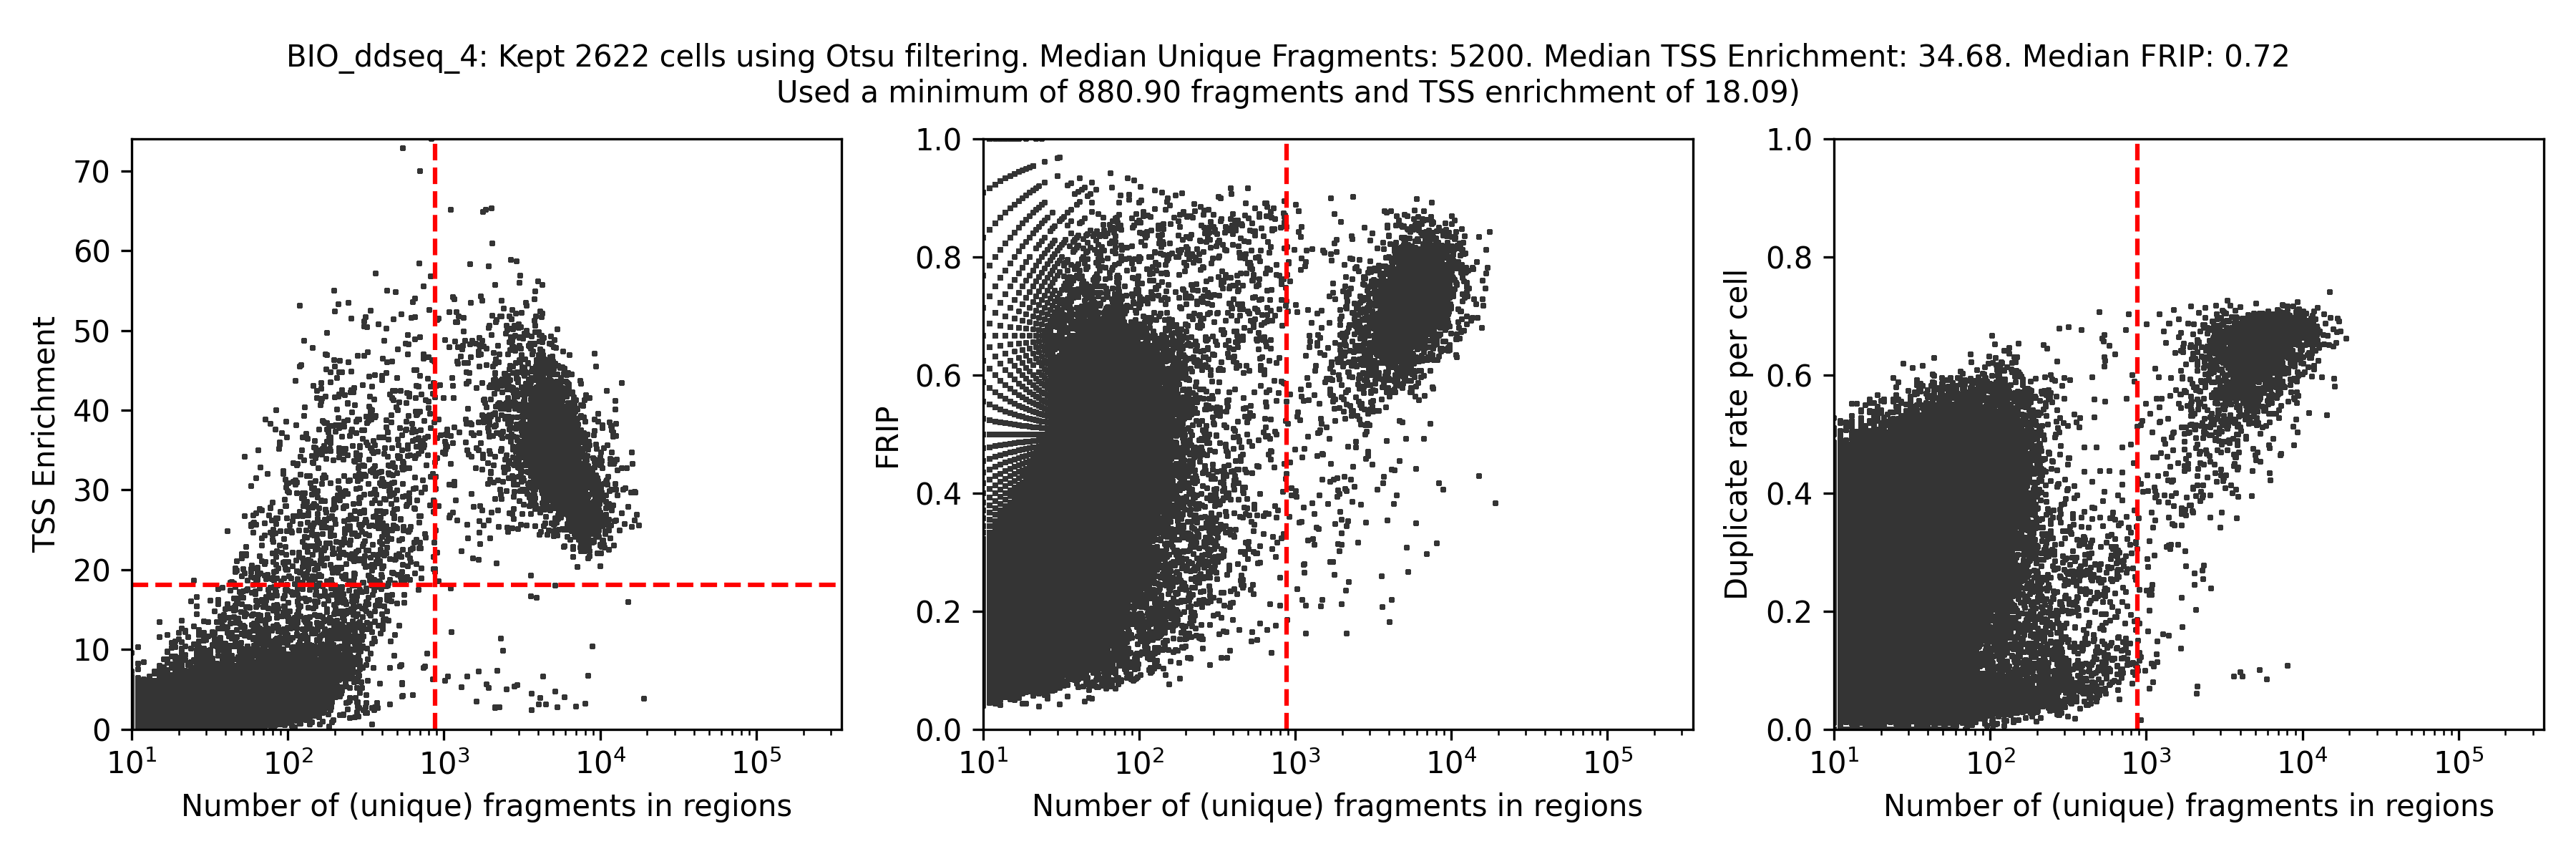

selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


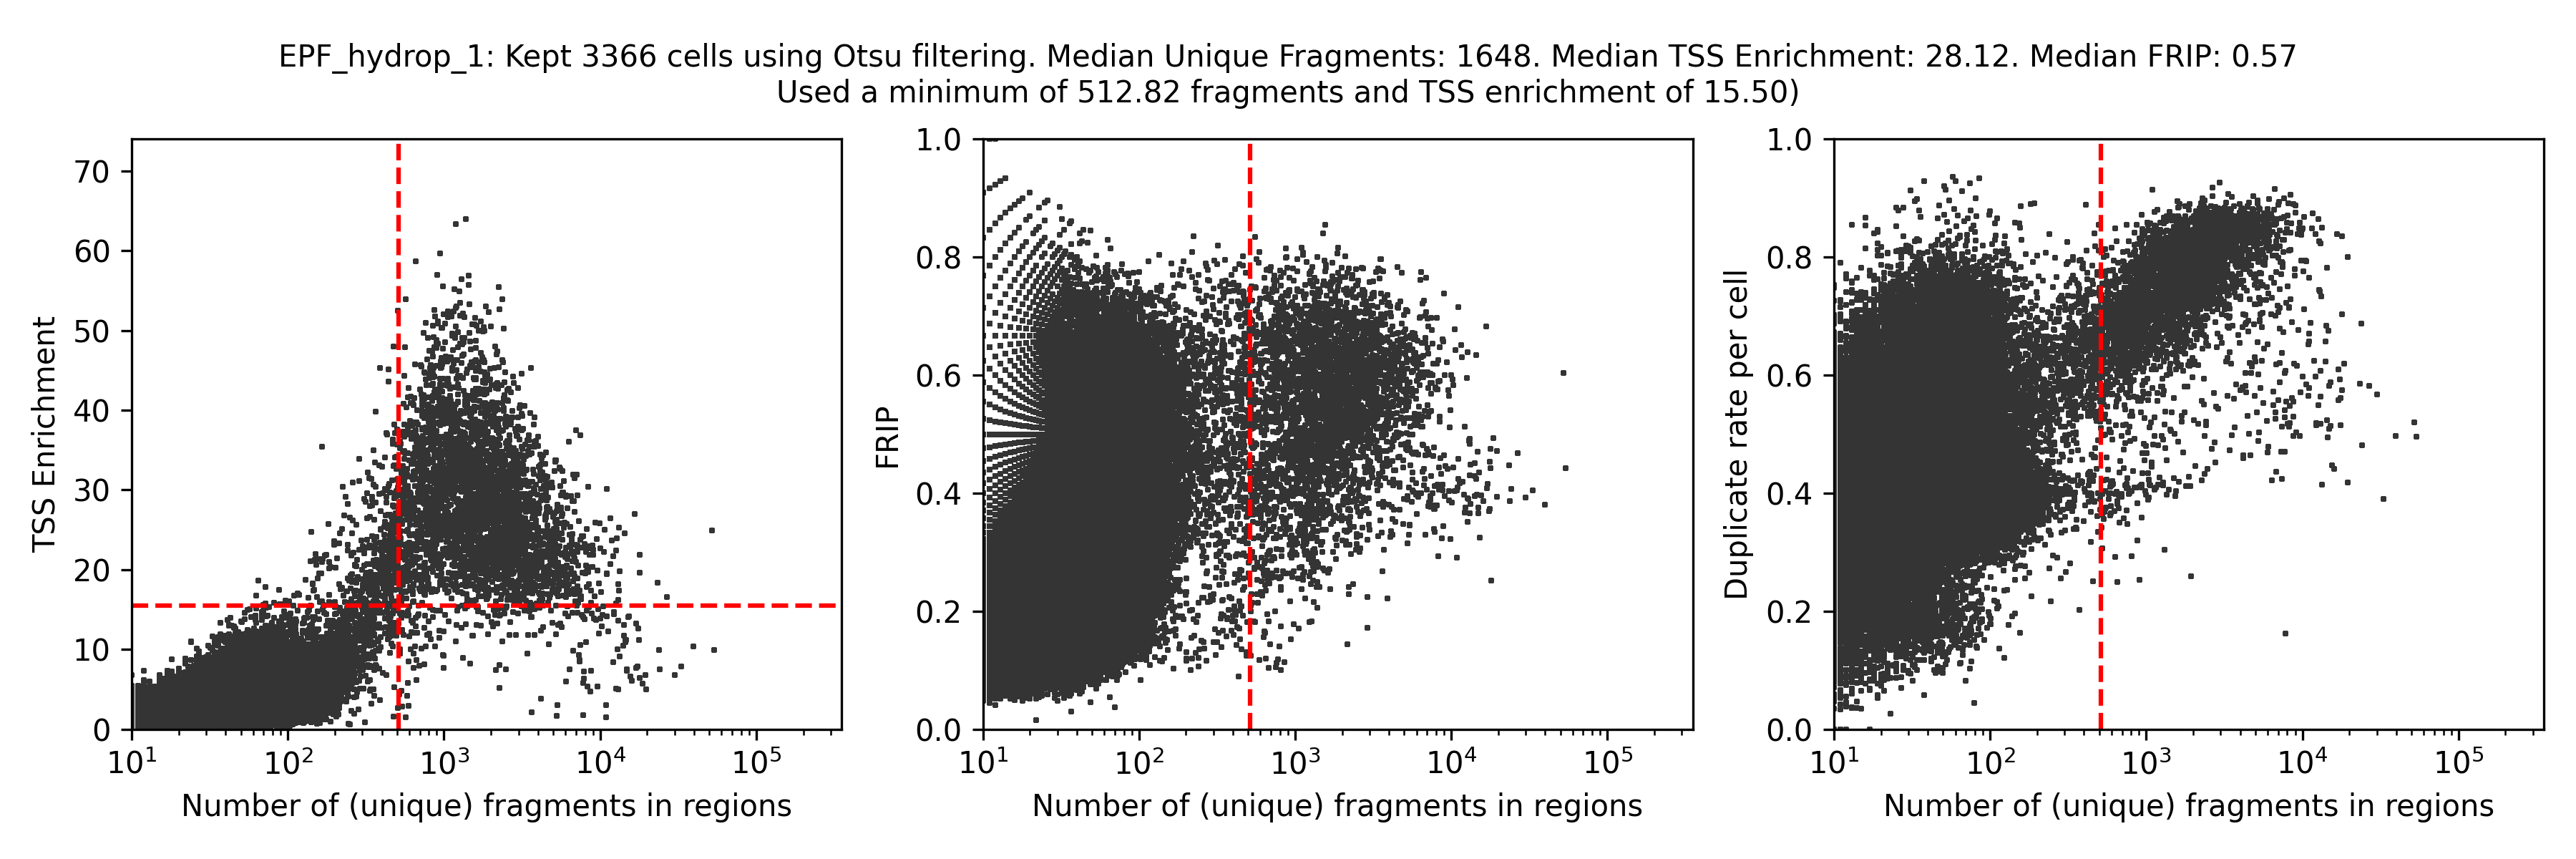

selected_barcodes/OHS_s3atac_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


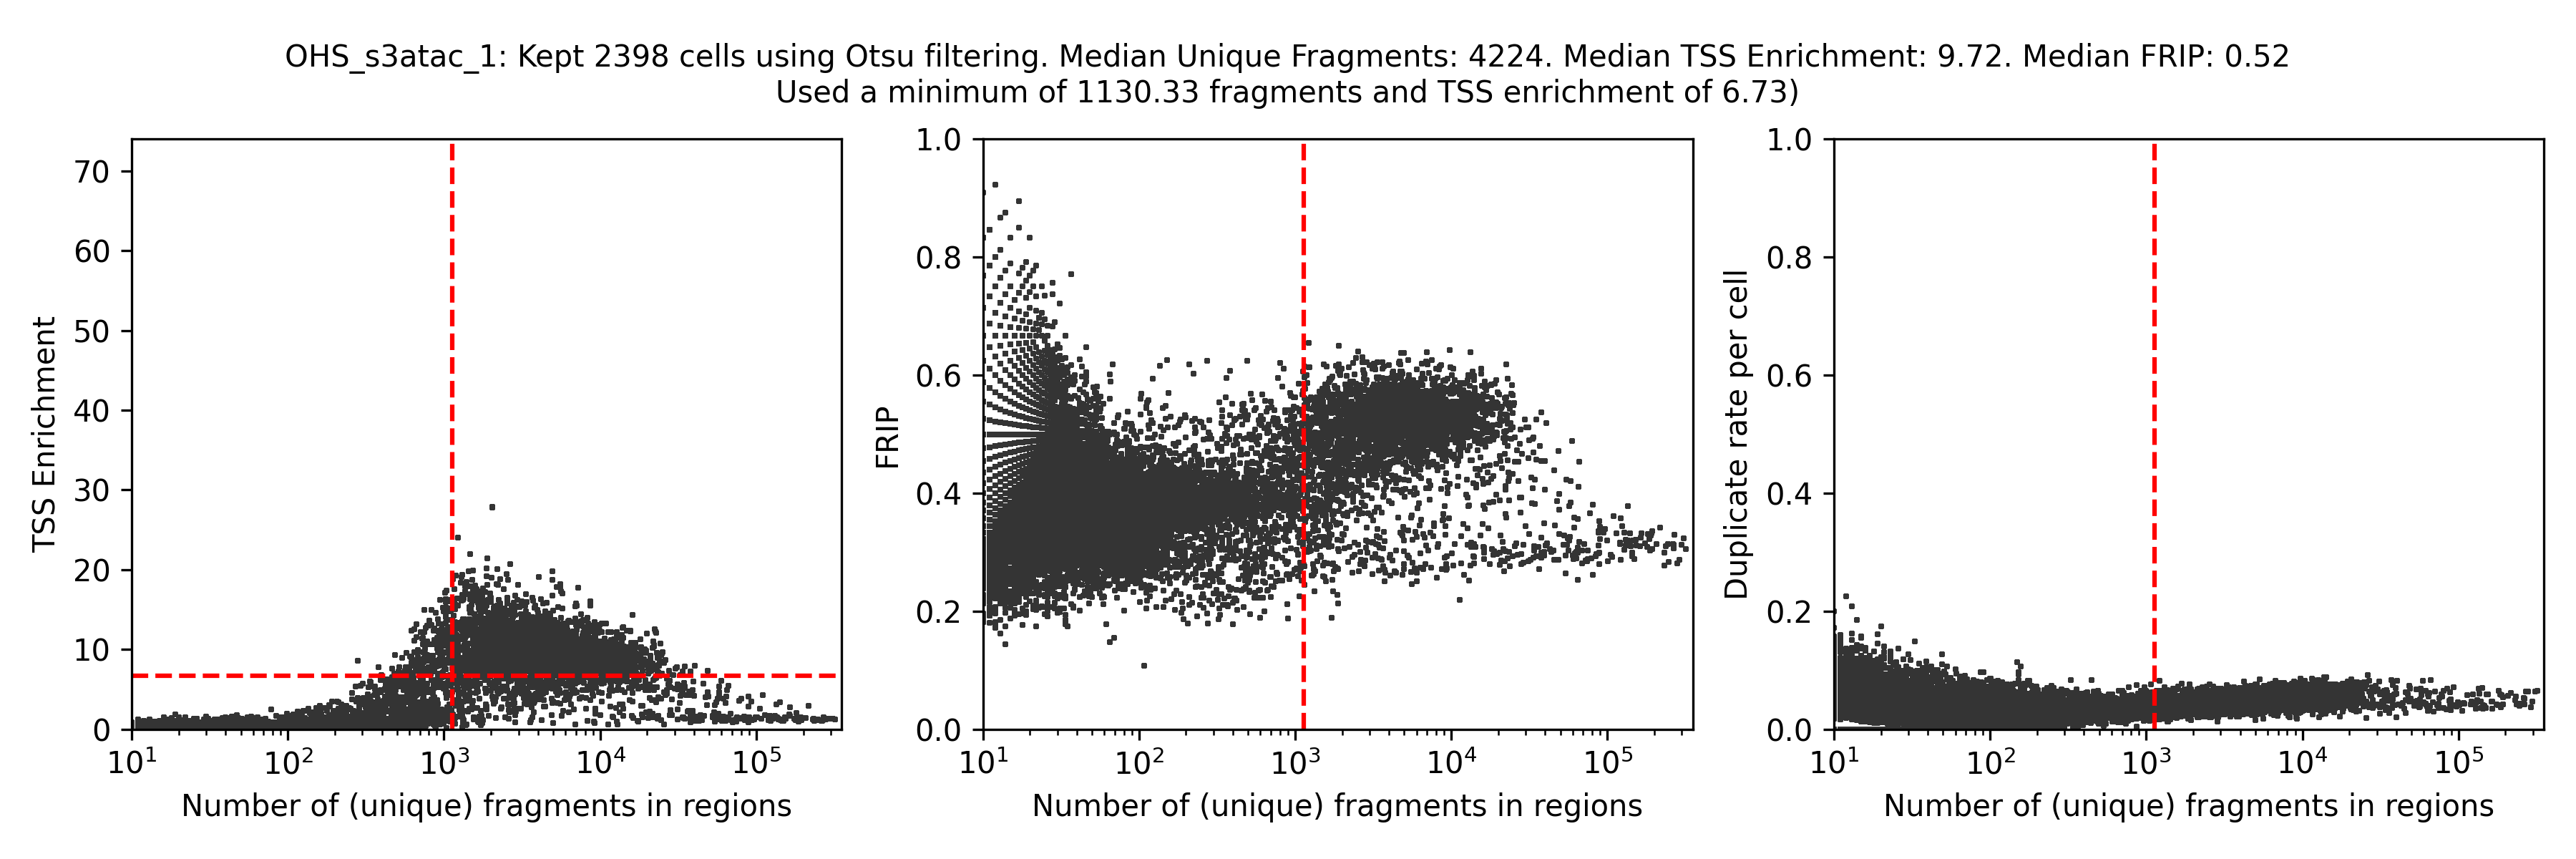

selected_barcodes/TEW__18d159__fe5107__Multiome_Liver_CCL4_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


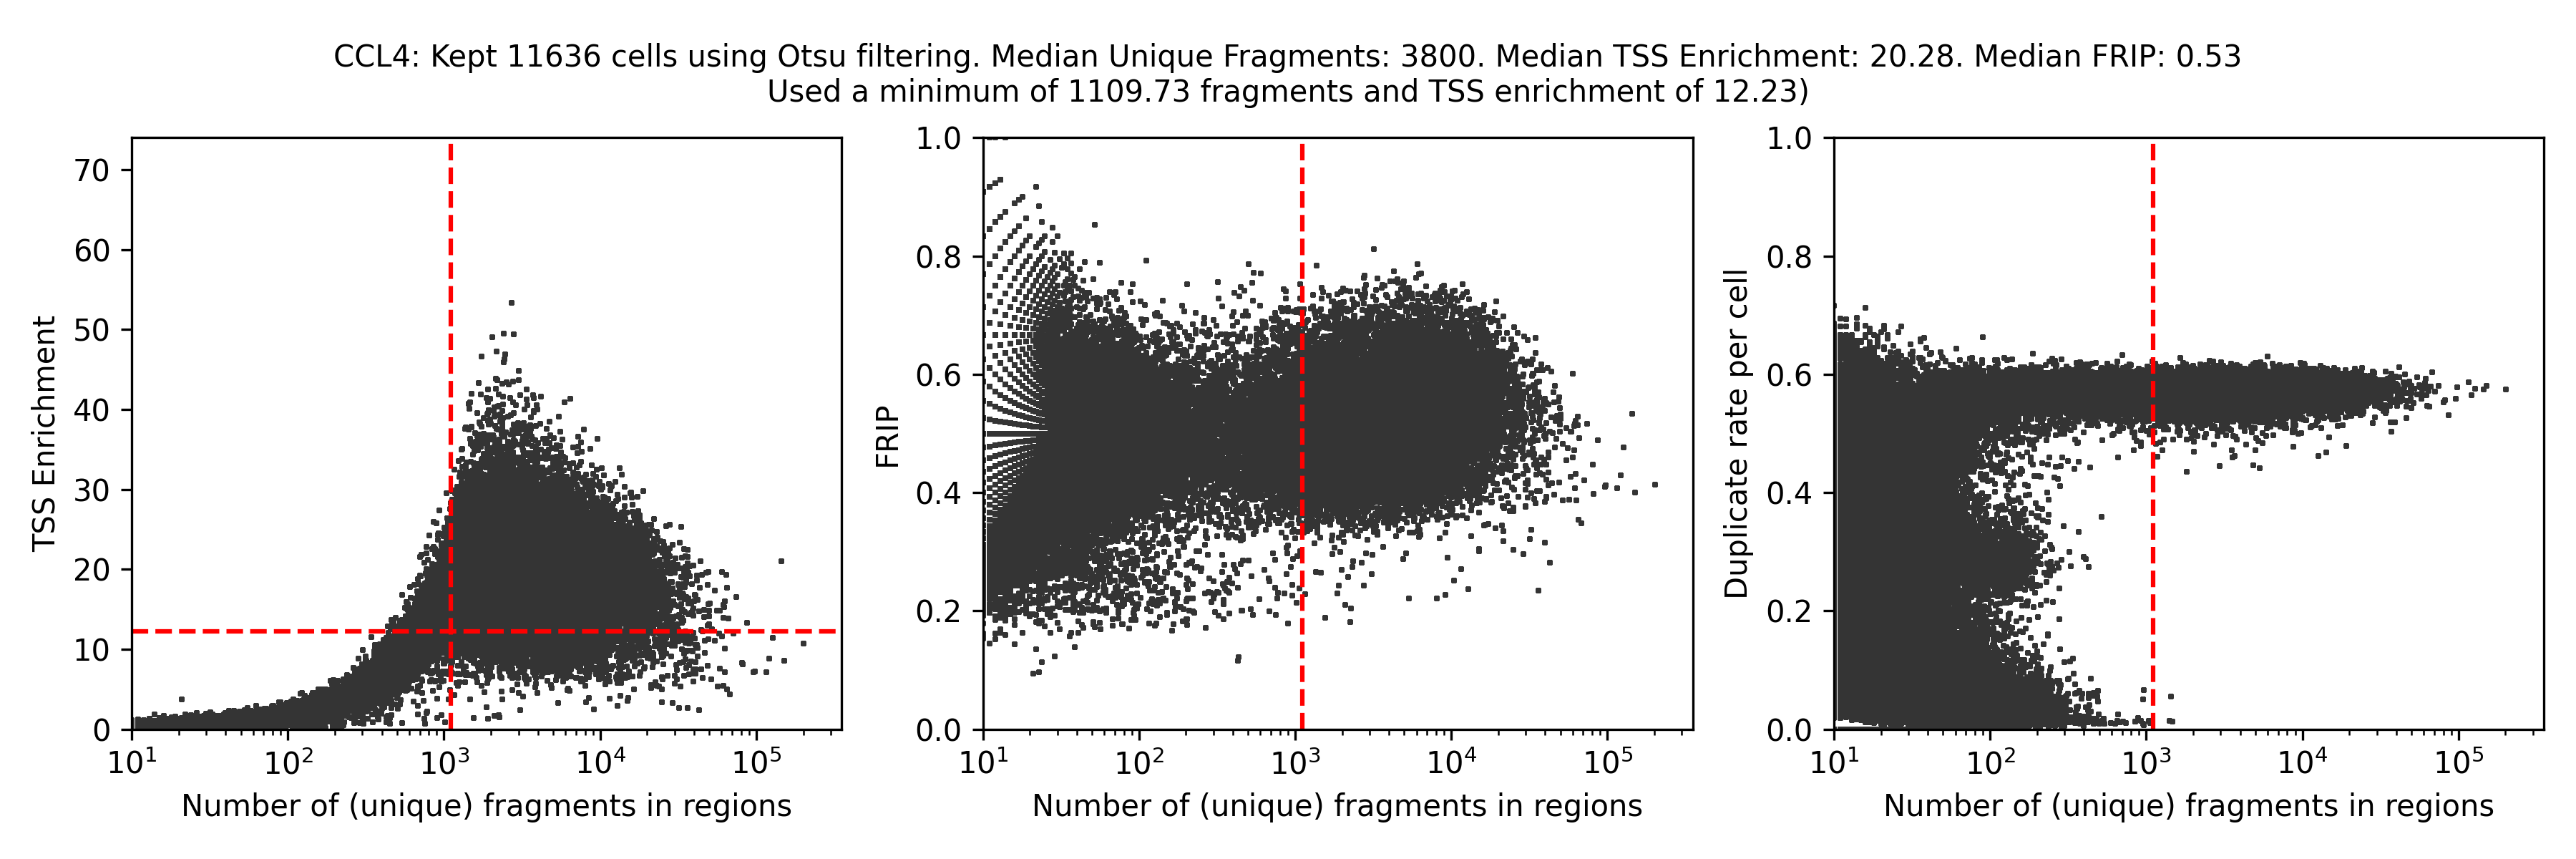

selected_barcodes/TEW__703a9e__28aa75__Multiome_Liver_CTRL_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


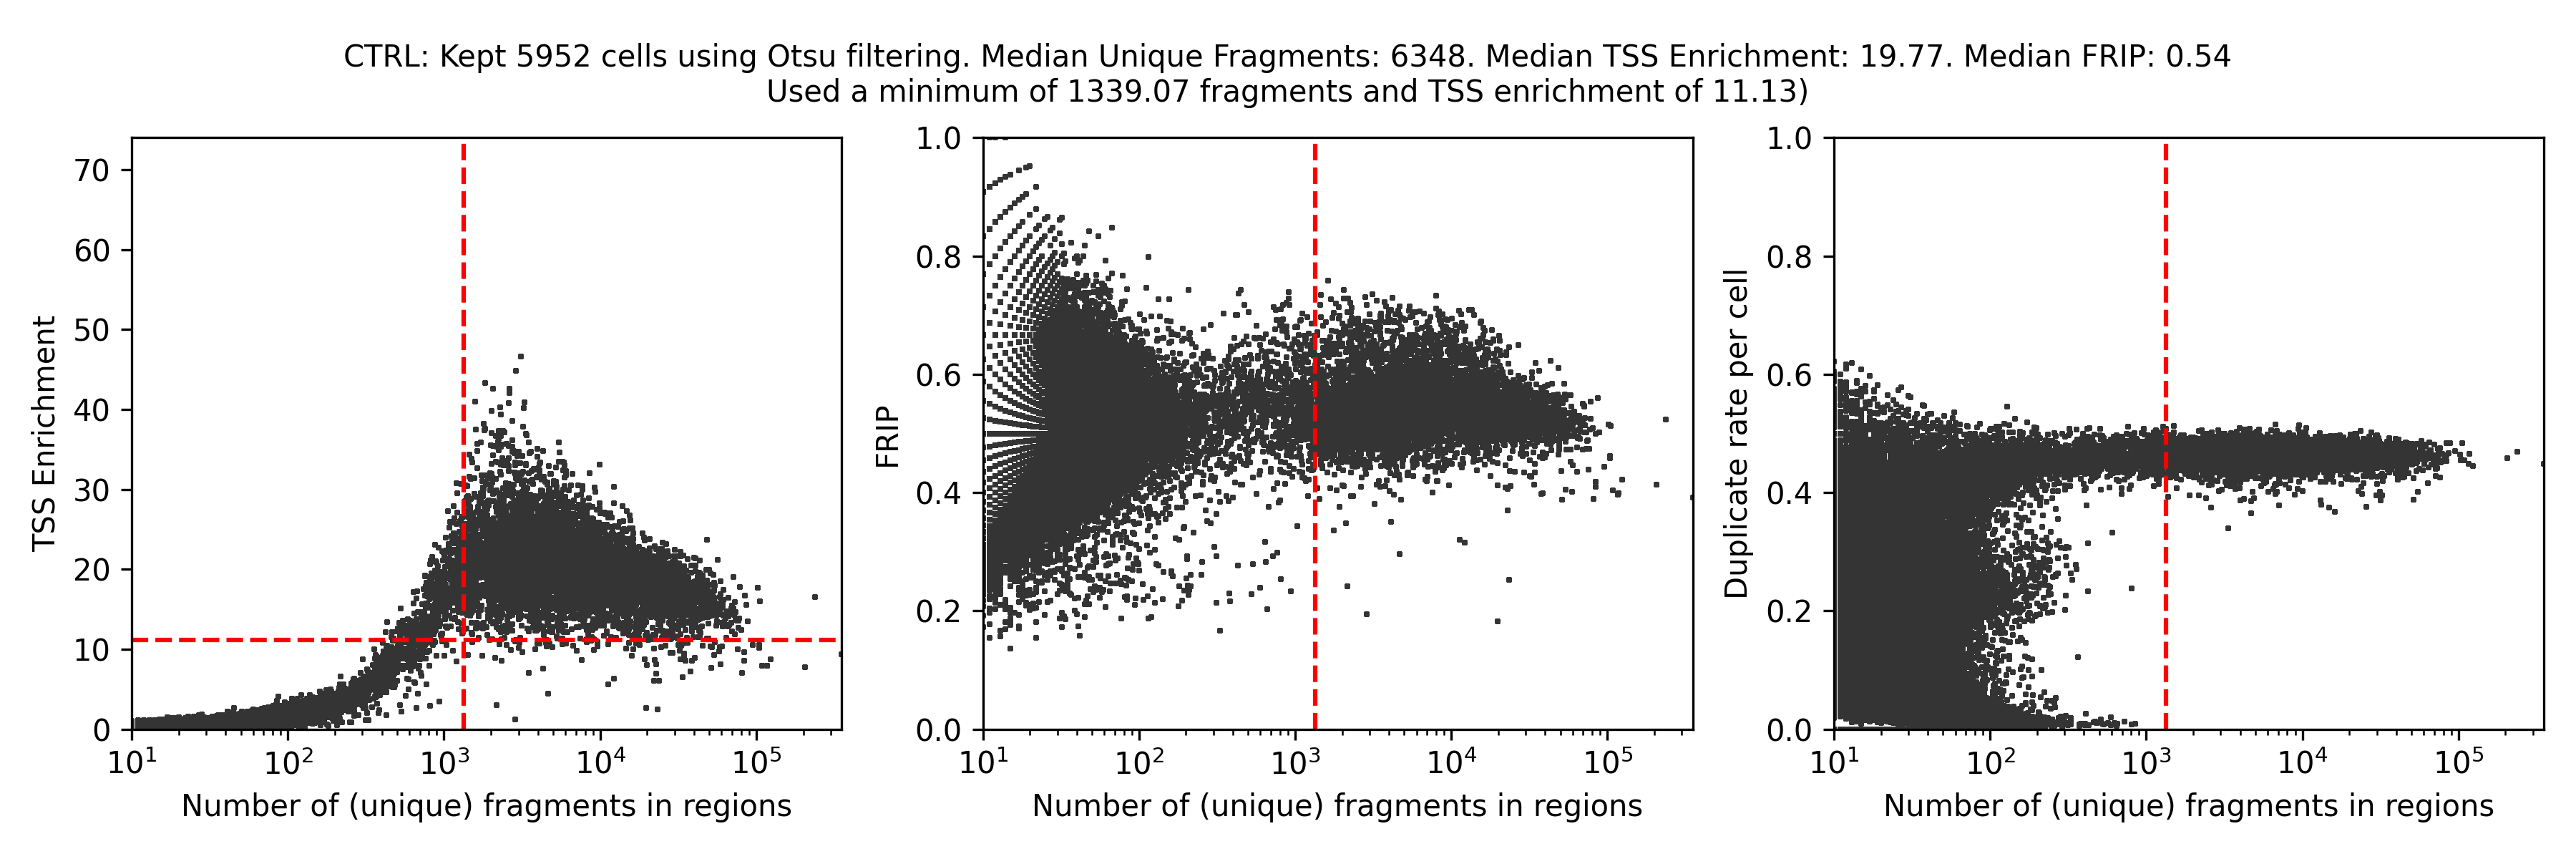

selected_barcodes/VIB_10xv2_1_bc_passing_filters_otsu.pkl bc passing filters exists, skipping...


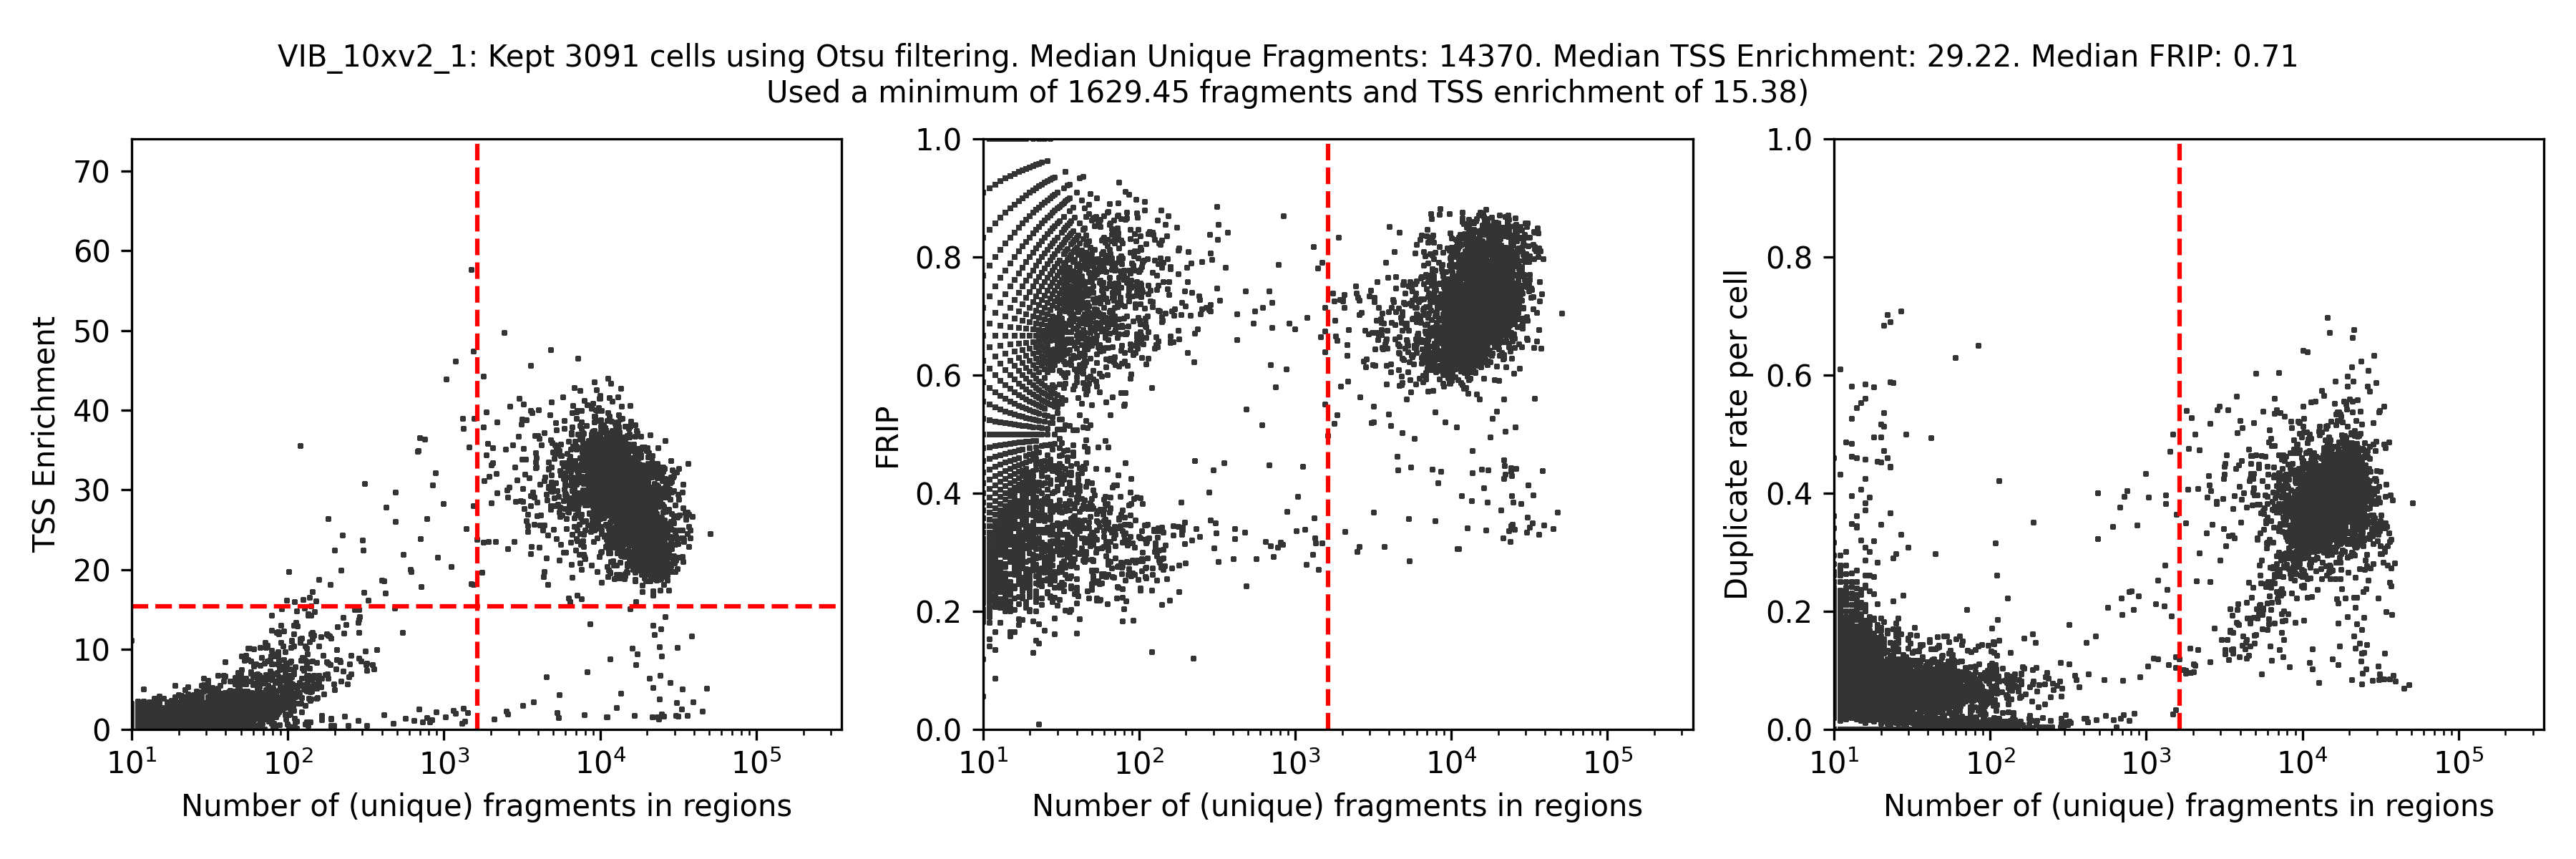

In [32]:
for sample in metadata_bc_pkl_path_dict.keys():
    pkl_path = f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl"
    if os.path.exists(pkl_path):
        print(f"{pkl_path} bc passing filters exists, skipping...")
        display(Image(filename=f"plots_qc/{sample}_qc_otsu.png"))

    else:
        print(f"{pkl_path} bc passing filters does not exist yet, generating...")
        print(f"\tLoading {metadata_bc_pkl_path_dict[sample]}")
        with open(metadata_bc_pkl_path_dict[sample], "rb") as fh:
            metadata_bc_df = pickle.load(fh)

        print(f"\tFiltering cells and generating QC plots.")
        if not sample in min_otsu_frags_dict.keys():
            print(
                f"\t{sample} not in minimum dict! Using standard value of {standard_min_x_val}"
            )
            min_x_val = standard_min_x_val
            min_y_val = standard_min_y_val
        else:
            min_x_val = min_otsu_frags_dict[sample]
            min_y_val = min_otsu_tss_dict[sample]

        bc_passing_filters, fig = pum.plot_qc(
            sample=sample,
            sample_alias=alias_dict[sample],
            min_dict=min_dict,
            max_dict=max_dict,
            metadata_bc_df=metadata_bc_df,
            include_kde=kde,
            min_x_val=min_x_val,
            min_y_val=min_y_val,
        )

        plt.tight_layout()
        plt.savefig(f"plots_qc/{sample}_qc_otsu.png", dpi=300, facecolor="white")
        plt.show()
        plt.close()

        print(f"\tSaving...")
        with open(
            f"selected_barcodes/{sample}_bc_passing_filters_otsu.pkl", "wb"
        ) as fh:
            pickle.dump(bc_passing_filters, fh)
        fh.close()

        fh = open(f"selected_barcodes/{sample}_bc_passing_filters_otsu.txt", "w")
        for bc in list(bc_passing_filters):
            fh.write(bc + "\n")
        fh.close()

        metadata_bc_df.loc[bc_passing_filters].to_csv(
            f"selected_barcodes/{sample}_metadata_bc_df.tsv", sep="\t"
        )

# Plot profile data

In [33]:
profile_data_pkl_path_dict = {
    os.path.basename(x).split("__profile_data.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*__profile_data.pkl"))
}
profile_data_pkl_path_dict

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__profile_data.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__profile_data.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__profile_data.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__profile_data.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__profile_data.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__profile_data.pkl'}

In [34]:
plot_sample_metrics

<function pycisTopic.qc.plot_sample_metrics(profile_data_dict: Dict[str, pandas.core.frame.DataFrame], profile_list: Union[ForwardRef('barcode_rank_plot'), ForwardRef('duplicate_rate'), ForwardRef('insert_size_distribution'), ForwardRef('profile_tss'), ForwardRef('frip'), NoneType] = ['barcode_rank_plot', 'duplicate_rate', 'insert_size_distribution', 'profile_tss', 'frip'], remove_duplicates: Union[bool, NoneType] = True, color: Union[List[List[str]], NoneType] = None, cmap: Union[str, NoneType] = None, ncol: Union[int, NoneType] = 1, figsize: Union[Tuple[int, int], NoneType] = None, insert_size_distriubtion_xlim: Union[List[int], NoneType] = None, legend_outside: Union[bool, NoneType] = False, duplicate_rate_as_hexbin: Union[bool, NoneType] = False, plot: Union[bool, NoneType] = True, save: Union[str, NoneType] = None)>

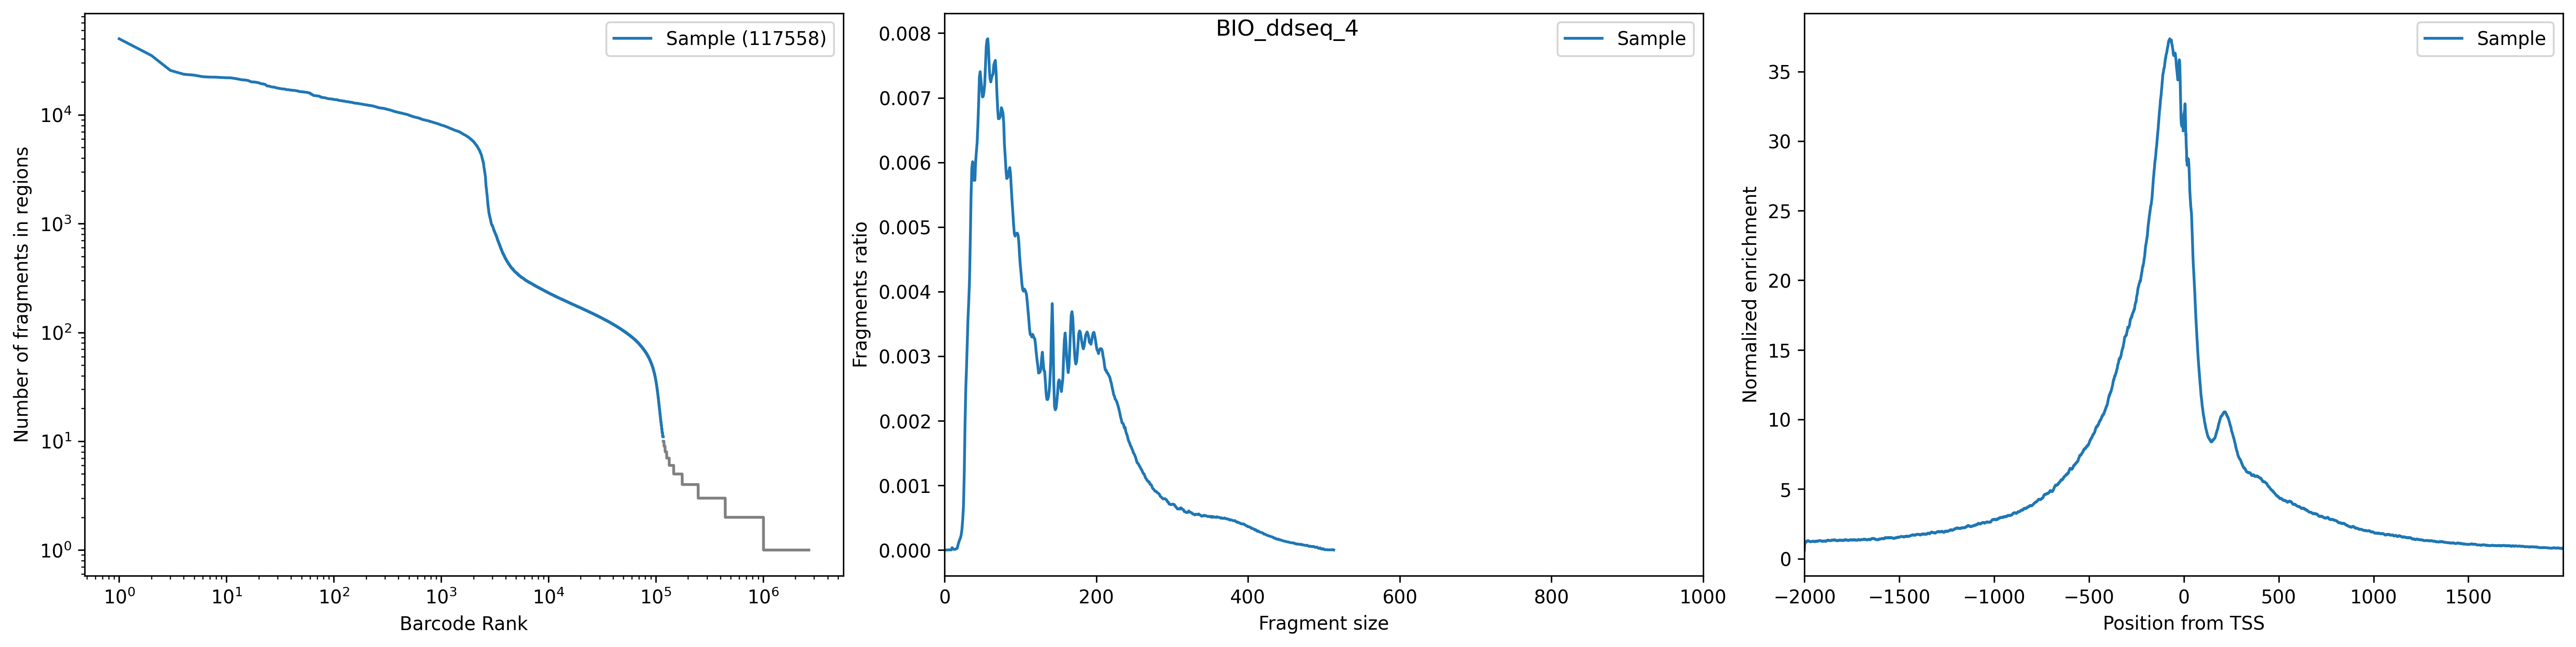

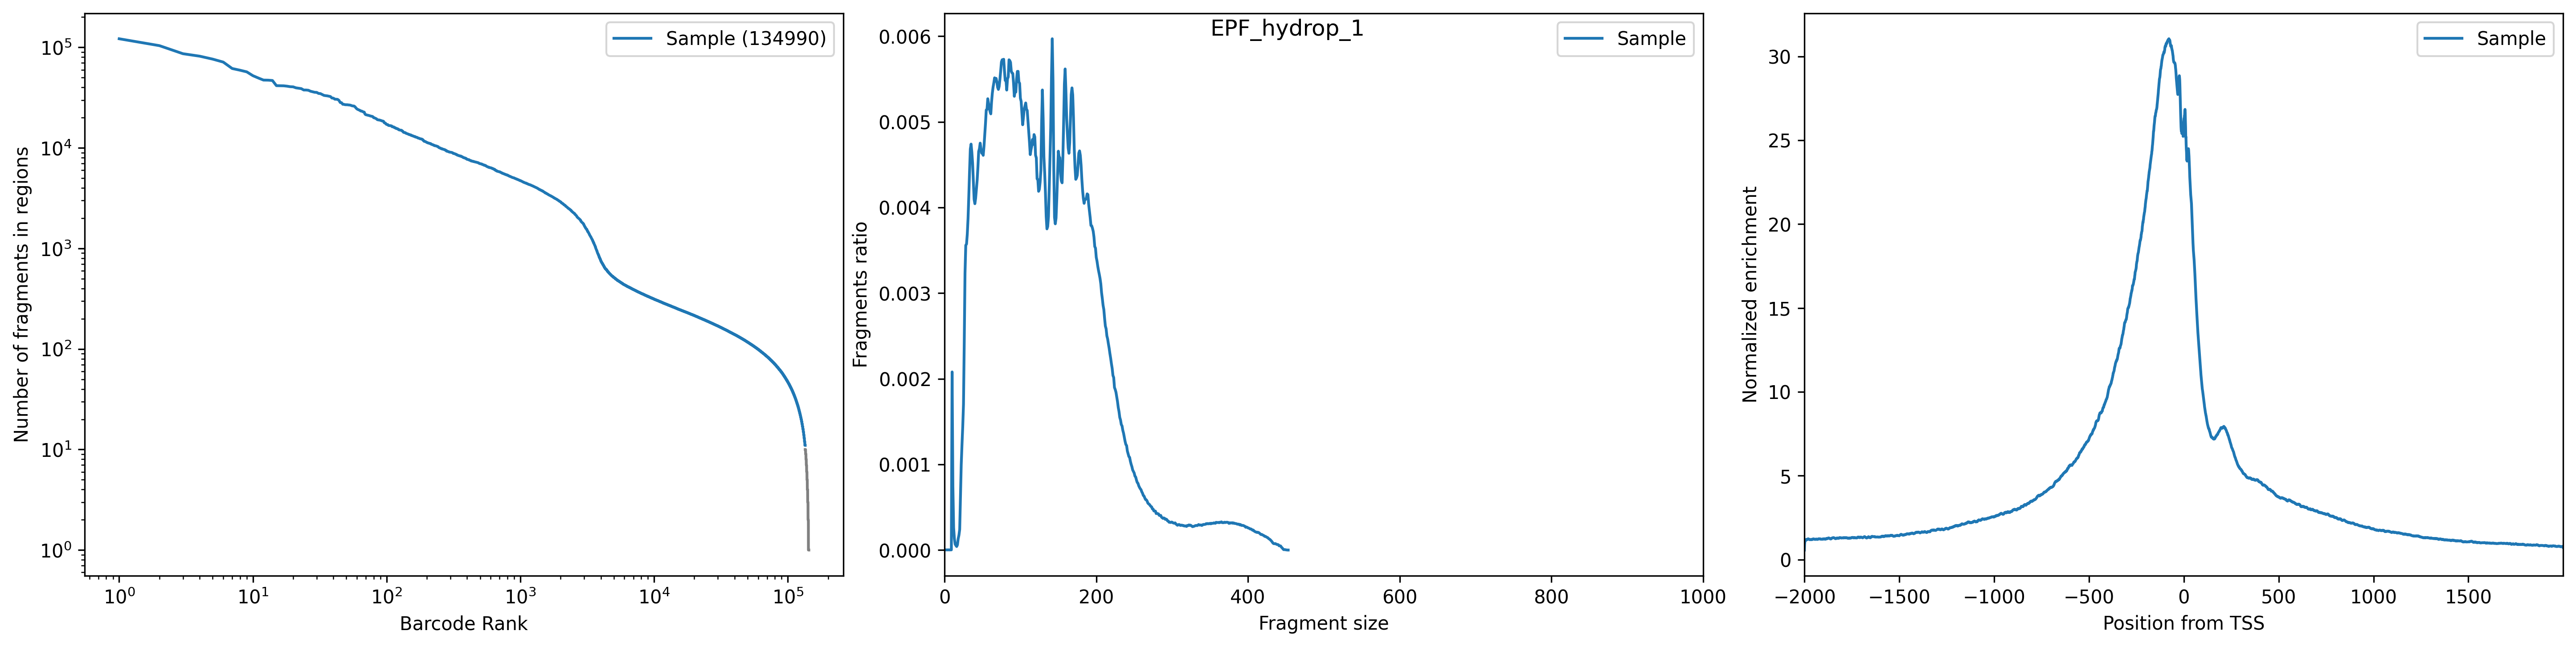

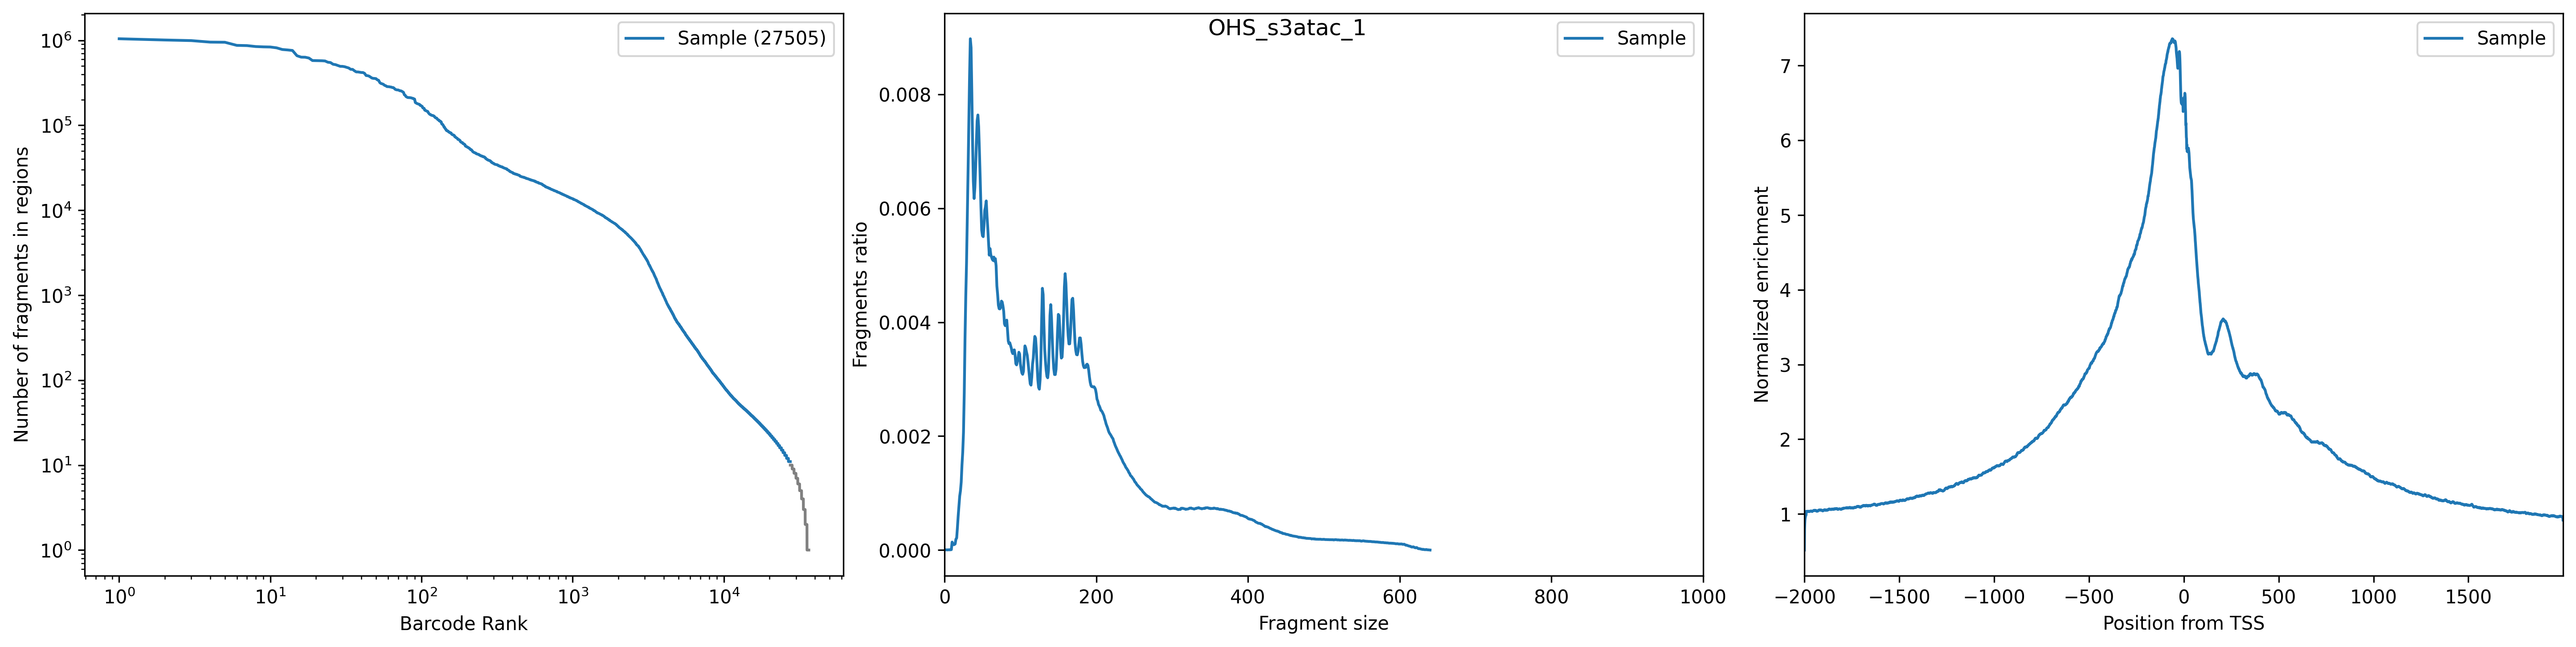

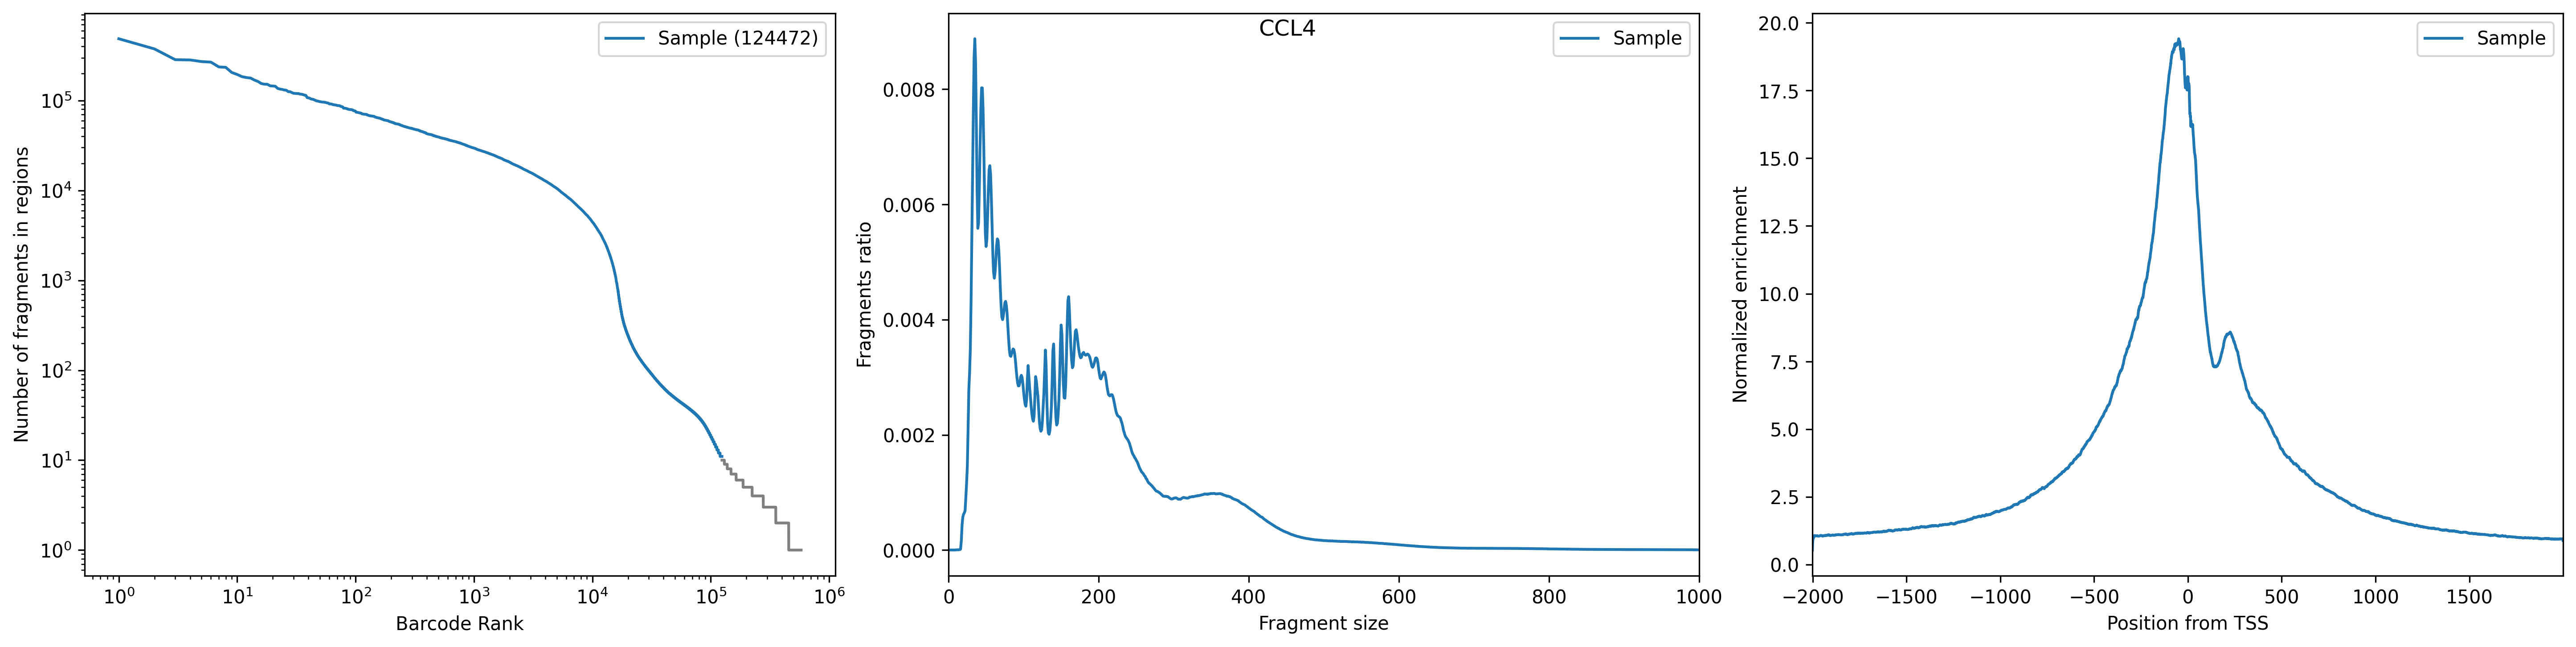

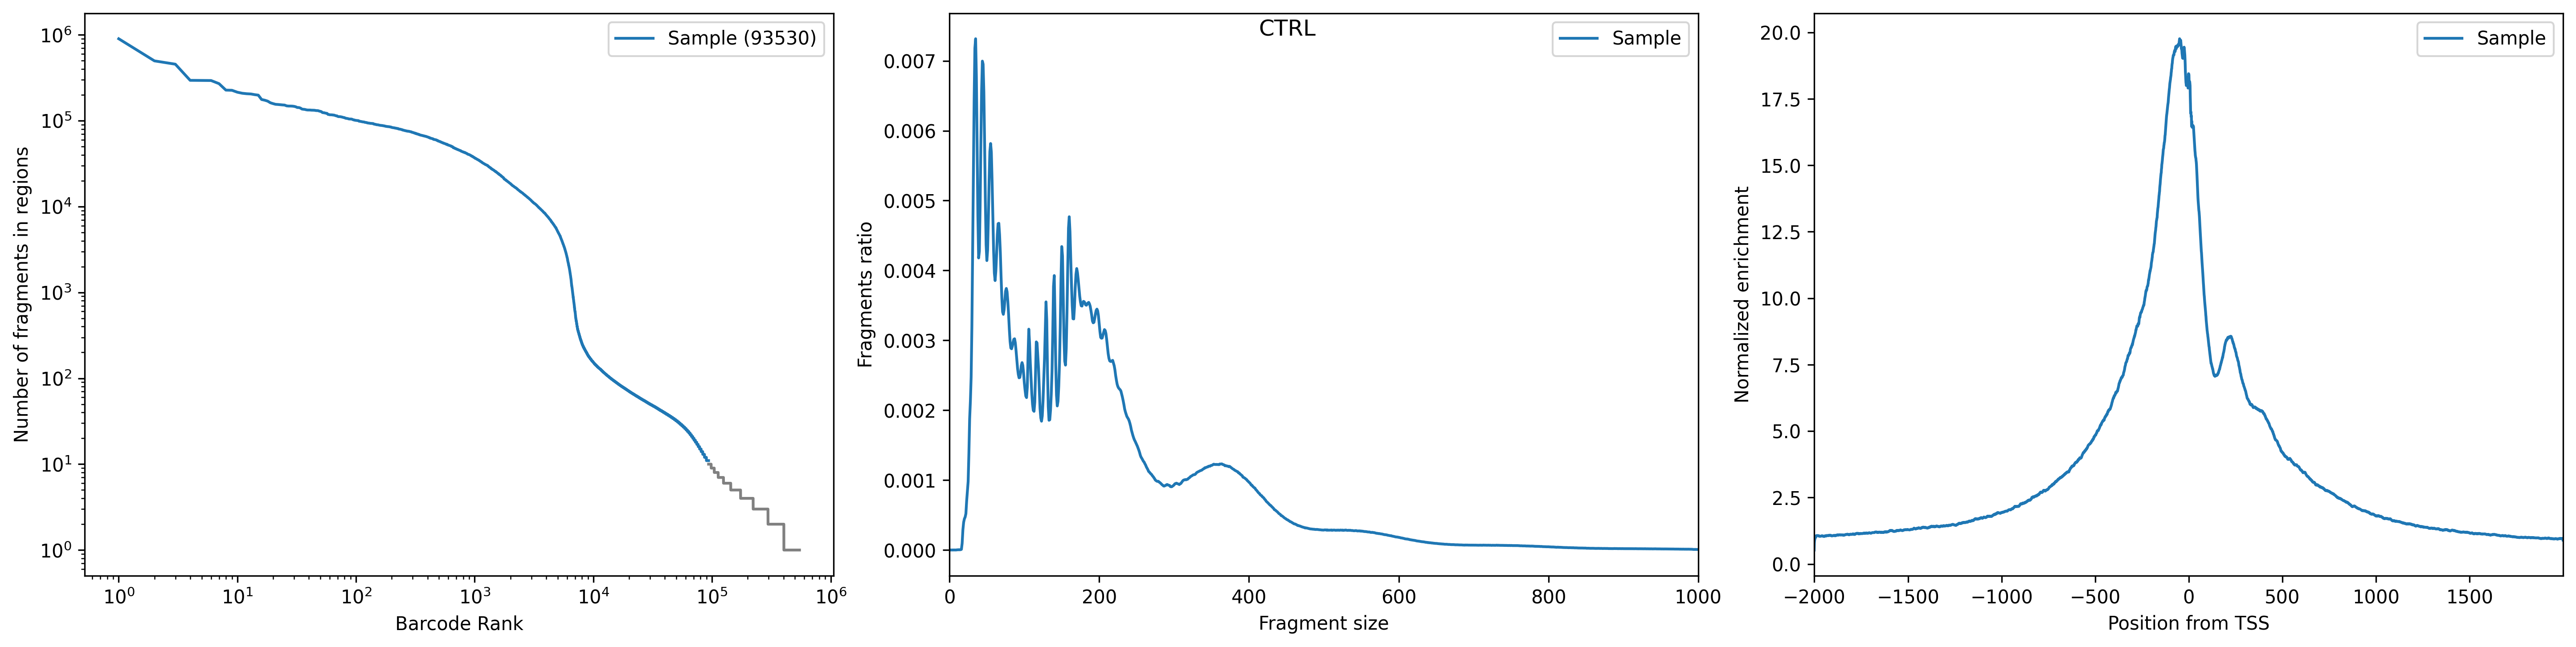

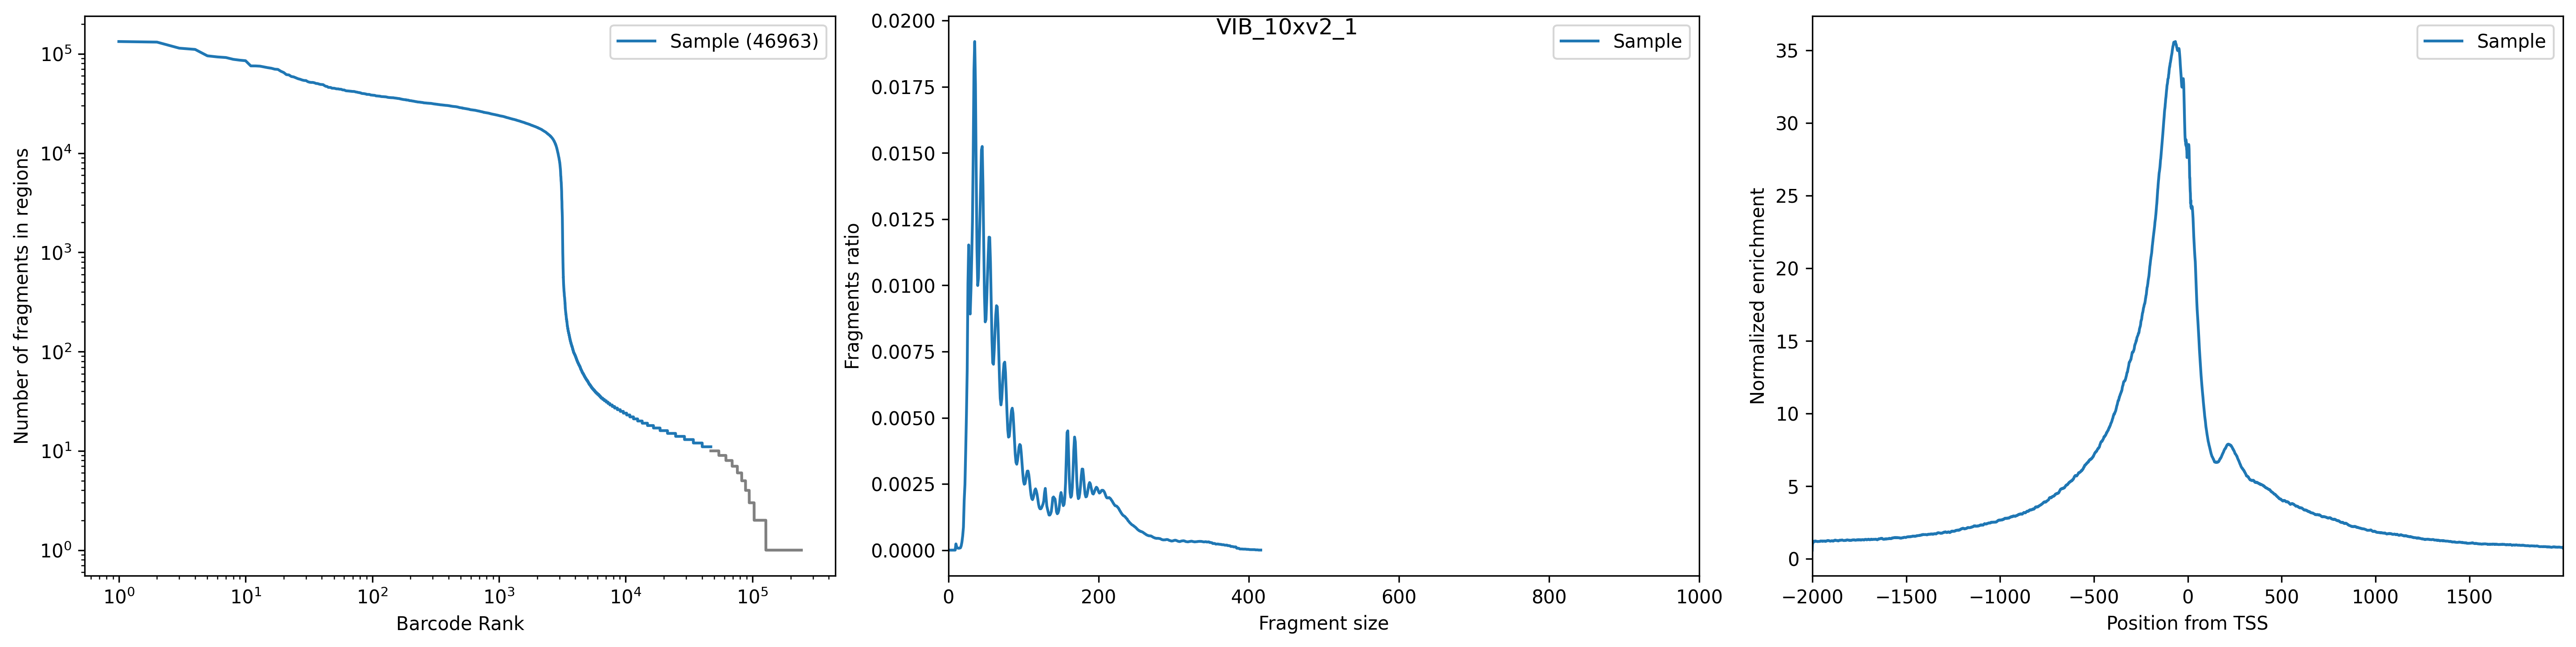

In [35]:
for sample, path in profile_data_pkl_path_dict.items():
    if not os.path.exists(f"plots_qc/{sample}_profile_metrics.png"):
        with open(path, "rb") as fh:
            profile_data_dict = pickle.load(fh)
        with warnings.catch_warnings():
            warnings.simplefilter(action="ignore", category=FutureWarning)
            plot_sample_metrics(
                profile_data_dict,
                ncol=3,
                plot=True,
                profile_list=[
                    "barcode_rank_plot",
                    "insert_size_distribution",
                    "profile_tss",
                ],
                insert_size_distriubtion_xlim=[0, 1000],
            )
            plt.suptitle(alias_dict[sample])
            plt.savefig(
                fname=f"plots_qc/{sample}_profile_metrics.png",
                dpi=300,
                bbox_inches="tight",
                facecolor="white",
            )
            plt.show()
    else:
        display(Image(filename=f"plots_qc/{sample}_profile_metrics.png"))

# 2. Gather QC stats from pipeline output and cisTopic
No need to read this, we are parsing information needed to make the plots below.

In [88]:
fragments_path_dict

{'BIO_ddseq_4': 'PUMATAC_tutorial_preprocessing_out/data/fragments/BIO_ddseq_4.fragments.tsv.gz',
 'EPF_hydrop_1': 'PUMATAC_tutorial_preprocessing_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz',
 'OHS_s3atac_1': 'PUMATAC_tutorial_preprocessing_out/data/fragments/OHS_s3atac_1.fragments.tsv.gz',
 'VIB_10xv2_1': 'PUMATAC_tutorial_preprocessing_out/data/fragments/VIB_10xv2_1.fragments.tsv.gz',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cellranger_out/TEW__18d159__fe5107__Multiome_Liver_CCL4/outs/atac_fragments.tsv.gz',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cellranger_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL/outs/atac_fragments.tsv.gz'}

In [89]:
df_stats = pum.scrape_mapping_stats(
    fragments_path_dict=fragments_path_dict,
    pipeline_dict=pipeline_dict,
    verbose=True,
)
df_stats

loading barcode stats files: ['PUMATAC_tutorial_preprocessing_out/data/reports/barcode/BIO_ddseq_4.corrected.bc_stats.log']
loading mapping stats files: ['PUMATAC_tutorial_preprocessing_out/data/reports/mapping_stats/BIO_ddseq_4_____R1.mapping_stats.tsv']
read 1 length: 54
read 2 length: 40
average map quality: 31.4
percent mapq30: 87.26
insert size average: 129.1
-------------------------------------

loading barcode stats files: ['PUMATAC_tutorial_preprocessing_out/data/reports/barcode/EPF_hydrop_1.corrected.bc_stats.log']
loading mapping stats files: ['PUMATAC_tutorial_preprocessing_out/data/reports/mapping_stats/EPF_hydrop_1_____R1.mapping_stats.tsv']
read 1 length: 49
read 2 length: 48
average map quality: 32.7
percent mapq30: 83.4
insert size average: 131.2
-------------------------------------

loading barcode stats files: ['PUMATAC_tutorial_preprocessing_out/data/reports/barcode/OHS_s3atac_1.corrected.bc_stats.log']
loading mapping stats files: ['PUMATAC_tutorial_preprocessing_

sample_id   
BIO_ddseq_4                                                            BIO_ddseq_4  \
EPF_hydrop_1                                                          EPF_hydrop_1   
OHS_s3atac_1                                                          OHS_s3atac_1   
VIB_10xv2_1                                                            VIB_10xv2_1   
TEW__18d159__fe5107__Multiome_Liver_CCL4  TEW__18d159__fe5107__Multiome_Liver_CCL4   
TEW__703a9e__28aa75__Multiome_Liver_CTRL  TEW__703a9e__28aa75__Multiome_Liver_CTRL   

                                          n_cells      n_reads   
BIO_ddseq_4                                2621.0  108112191.0  \
EPF_hydrop_1                               3365.0  132665741.0   
OHS_s3atac_1                               2397.0  127311784.0   
VIB_10xv2_1                                3090.0  126713277.0   
TEW__18d159__fe5107__Multiome_Liver_CCL4  11635.0  482718785.0   
TEW__703a9e__28aa75__Multiome_Liver_CTRL   5951.0  283997270.0   

                                          %_correct_barcodes  r1_length   
BIO_ddseq_4                                            88.10       54.0  \
EPF_hydrop_1                                           93.66       49.0   
OHS_s3atac_1                                          100.00       85.0   
VIB_10xv2_1                                            96.20       50.0   
TEW__18d159__fe5107__Multiome_Liver_CCL4               98.72        NaN   
TEW__703a9e__28aa75__Multiome_Liver_CTRL               98.68        NaN   

                                          r2_length  avg_insert_size   
BIO_ddseq_4                                    40.0            129.0  \
EPF_hydrop_1                                   48.0            131.0   
OHS_s3atac_1                                   67.0            157.0   
VIB_10xv2_1                                    50.0            103.0   
TEW__18d159__fe5107__Multiome_Liver_CCL4        NaN              NaN   
TEW__703a9e__28aa75__Multiome_Liver_CTRL        NaN              NaN   

                                          %_mapq30  avg_map_quality  
BIO_ddseq_4                                  87.26             31.4  
EPF_hydrop_1                                 83.40             32.7  
OHS_s3atac_1                                 80.64             34.5  
VIB_10xv2_1                                  92.75             33.0  
TEW__18d159__fe5107__Multiome_Liver_CCL4     88.65              NaN  
TEW__703a9e__28aa75__Multiome_Liver_CTRL     89.75              NaN

### 3c. Single-cell level statistics

In [90]:
verbose = True

In [91]:
metadata_path_dict = {
    x.split("/")[-1].split(f"__metadata_bc.pkl")[0]: x
    for x in sorted(glob.glob(f"{cistopic_qc_out}/*metadata*pkl"))
}
if verbose:
    pp.pprint(metadata_path_dict)

{'BIO_ddseq_4': 'cistopic_qc_out/BIO_ddseq_4__metadata_bc.pkl',
 'EPF_hydrop_1': 'cistopic_qc_out/EPF_hydrop_1__metadata_bc.pkl',
 'OHS_s3atac_1': 'cistopic_qc_out/OHS_s3atac_1__metadata_bc.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'cistopic_qc_out/TEW__18d159__fe5107__Multiome_Liver_CCL4__metadata_bc.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'cistopic_qc_out/TEW__703a9e__28aa75__Multiome_Liver_CTRL__metadata_bc.pkl',
 'VIB_10xv2_1': 'cistopic_qc_out/VIB_10xv2_1__metadata_bc.pkl'}


In [92]:
selected_cells_path_dict = {
    x.split("/")[-1].split(f"_bc_passing_filters_otsu.pkl")[0]: x
    for x in sorted(glob.glob(f"selected_barcodes/*.pkl"))
}
if verbose:
    pp.pprint(selected_cells_path_dict)

{'BIO_ddseq_4': 'selected_barcodes/BIO_ddseq_4_bc_passing_filters_otsu.pkl',
 'EPF_hydrop_1': 'selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.pkl',
 'OHS_s3atac_1': 'selected_barcodes/OHS_s3atac_1_bc_passing_filters_otsu.pkl',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'selected_barcodes/TEW__18d159__fe5107__Multiome_Liver_CCL4_bc_passing_filters_otsu.pkl',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'selected_barcodes/TEW__703a9e__28aa75__Multiome_Liver_CTRL_bc_passing_filters_otsu.pkl',
 'VIB_10xv2_1': 'selected_barcodes/VIB_10xv2_1_bc_passing_filters_otsu.pkl'}


Read the cisTopic output.

In [93]:
df_scstats_merged, df_stats = pum.scrape_scstats(
    metadata_path_dict, selected_cells_path_dict, df_stats
)

These are variables necessary for plotting (order of samples, color palettes, ...)

Load the reference data from De Rop et al., 2023 and combine it with the user samples:

### 3d. Sequencing efficiency statistics

In [103]:
importlib.reload(pum)

<module 'pypumatac' from '/lustre1/project/stg_00002/lcb/fderop/data/PUMATAC_tutorial_dev/pypumatac.py'>

In [104]:
df_stats_merged = pum.calculate_losses(df_stats, df_scstats_merged)

# 3. Plot and compare to De Rop et al., 2023 benchmark

In [105]:
sns.set_context("notebook")
sns.set_style("darkgrid")

If you want, you can change the order in which your samples are plotted by manually editing key `user_sample` in the dictionary `order_dict_tech_ultrashort`

Some variables necessary for plotting.

In [106]:
order = [
    "tech",
    "No correct barcode",
    "Not mapped properly",
    "Fragments in noise barcodes",
    "Duplicate fragments in cells",
    "Unique, in cells, not in peaks",
    "Unique, in cells, in peaks",
]

order = order[::-1]

losses_color_palette = palettable.cartocolors.qualitative.Safe_7.get_mpl_colormap()

tech_alias_dict = {
    "10xmultiome": "10x\nMultiome",
    "10xv1": "10x v1",
    "10xv11": "10x v1.1",
    "10xv11c": "10x v1.1\ncontrols",
    "10xv2": "10x v2",
    "ddseq": "Bio-Rad\nddSEQ SureCell",
    "hydrop": "HyDrop",
    "mtscatac": "mtscATAC-seq",
    "mtscatacfacs": "*",
    "s3atac": "s3-ATAC",
    "user_sample": "User samples",
}

### 3a. Sequencing efficiency & Single-cell statistics

In [107]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

In [108]:
tech_order = [
    "10xv1",
    "10xv11",
    "10xv11c",
    "10xv2",
    "10xmultiome",
    "user_sample",
    "mtscatac",
    "mtscatacfacs",
    "ddseq",
    "s3atac",
    "hydrop",
]

In [109]:
ylim_dict = {
    "Unique_nr_frag_in_regions": [0, 20000],
    "Unique_nr_frag_in_regions_k": [0, 20],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, 45],
}

In [110]:
individual_barplot_width = 0.5
individual_plot_row_height = 4

/lustre1/project/stg_00002/lcb/fderop/data/PUMATAC_tutorial_dev/pypumatac.py:1814: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.close()


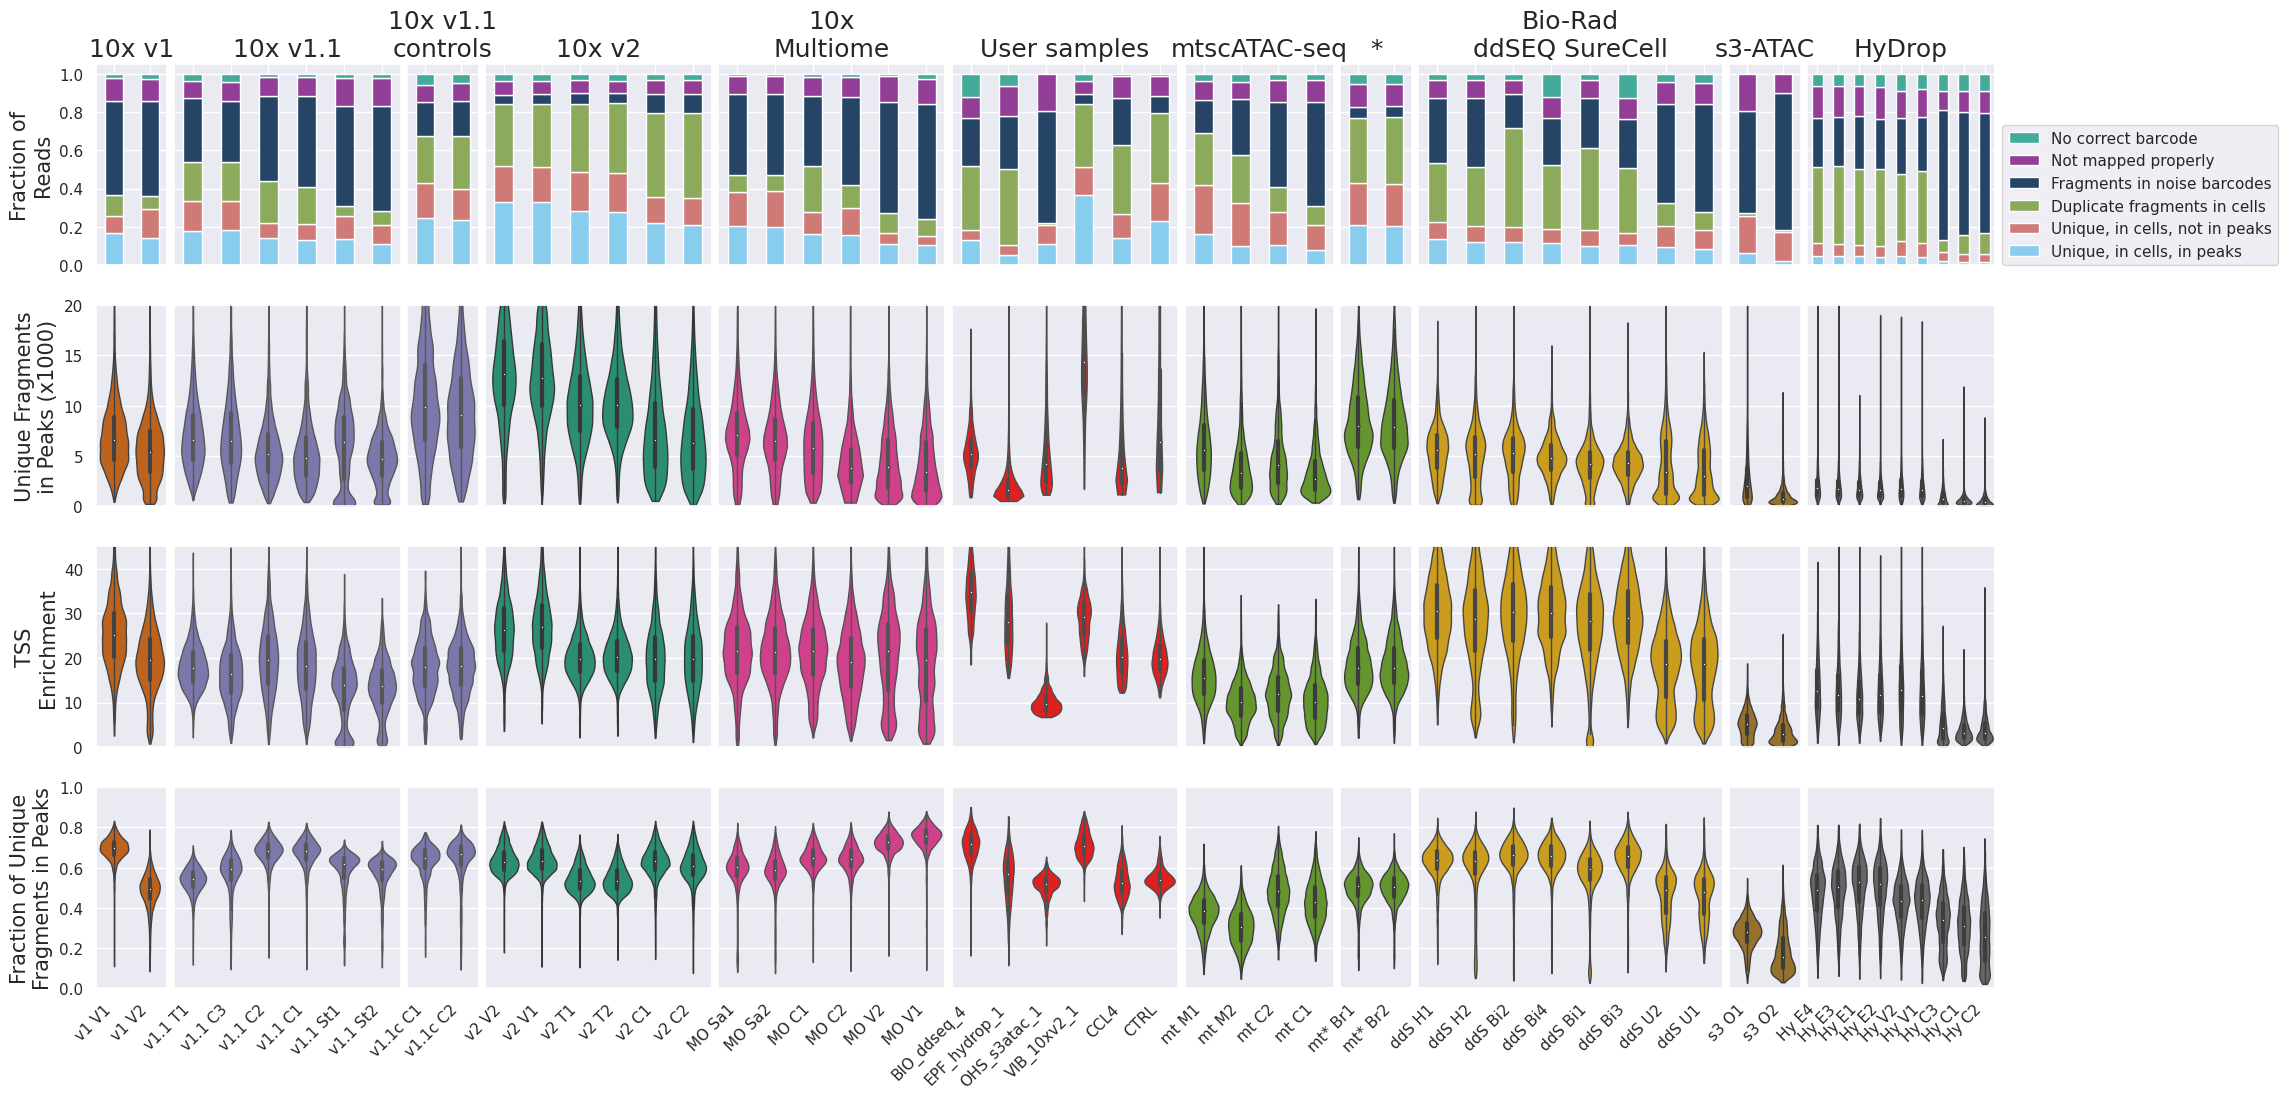

In [111]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    samples,
    alias_dict,
    tech_order,
    ylim_dict,
    svg_output_path="plots_qc/all_barplots.svg",
    png_output_path="plots_qc/all_barplots.png",
)

Only the user samples:

In [112]:
ymax_frags = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions"]
    .median()
    .max()
    * 2
)
ymax_frags_k = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["Unique_nr_frag_in_regions_k"]
    .median()
    .max()
    * 2
)
ymax_tss = (
    df_scstats_merged[df_scstats_merged["tech"] == "user_sample"]
    .groupby("sample_id")["TSS_enrichment"]
    .median()
    .max()
    * 2
)

ylim_dict = {
    "Unique_nr_frag_in_regions": [0, ymax_frags],
    "Unique_nr_frag_in_regions_k": [0, ymax_frags_k],
    "FRIP": [0, 1],
    "TSS_enrichment": [0, ymax_tss],
}

/lustre1/project/stg_00002/lcb/fderop/data/PUMATAC_tutorial_dev/pypumatac.py:1814: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.close()


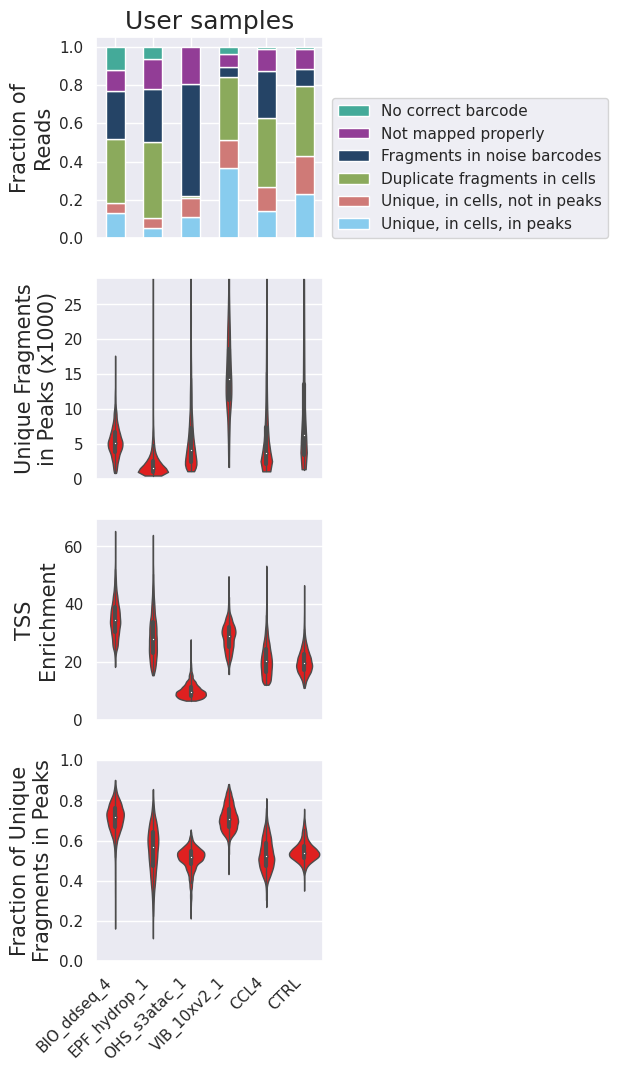

In [113]:
variables_list = ["Unique_nr_frag_in_regions_k", "TSS_enrichment", "FRIP"]

pum.plot_all_qc(
    df_stats_merged,
    df_scstats_merged,
    variables_list,
    samples,
    alias_dict,
    ["user_sample"],
    ylim_dict,
    svg_output_path="plots_qc/usersamples_barplots.svg",
    png_output_path="plots_qc/usersamples_barplots.png",
)

# 4. Saturation analysis

The following code subsets the `fragments.tsv.gz` file for selected cells, and then calculates the saturation within these selected cells.

First, load the barcodes we filtered as cells. Make sure that the barcodes match the barcodes in the fragments files! Take special care to remove any suffixes or prefixes that you may have added to the barcodes. For example, cisTopic adds `__{sample}` as a suffix to each barcode:

In [114]:
selected_barcodes_dict = {}
n_cells_dict = {}
for filepath in sorted(glob.glob("selected_barcodes/*pkl")):
    sample = os.path.basename(filepath).split("_bc")[0]
    with open(filepath, "rb") as f:
        selected_barcodes = list(pickle.load(f))
    selected_barcodes = [x.split("___")[0] for x in selected_barcodes]
    newfilepath = filepath.replace(".pkl", ".RAW.txt")
    with open(newfilepath, "w") as fp:
        for item in selected_barcodes:
            fp.write("%s\n" % item)

    selected_barcodes_dict[sample] = selected_barcodes
    n_cells_dict[sample] = len(selected_barcodes)

pp.pprint(n_cells_dict)

{'BIO_ddseq_4': 2622,
 'EPF_hydrop_1': 3366,
 'OHS_s3atac_1': 2398,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 11636,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 5952,
 'VIB_10xv2_1': 3091}


Get the number of reads per FASTQ

Make a directory where the saturation statistics will be written:

In [119]:
saturation_stats_path = "saturation_stats"
if not os.path.exists(saturation_stats_path):
    os.mkdir(saturation_stats_path)

Check which ones were already run:

In [120]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{}

### Calculate the downsampling statistics
We will now downsampled the fragments files at set intervals and calculate quality metrics on these downsampled sets. Then, we will use these datapoints to fit a curve and extrapolate further sequencing saturation.

Define the sampling fractions (levels to which we will downsample the fragments file and calculate saturation):

In [121]:
sampling_fractions = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97, 1]

### Option #1: Execute the downsampling script using singularity
This is preferred in case you have many fragments files and want to parallelize

In [123]:
raw_barcode_path = {
    os.path.basename(x).split("_bc")[0]: x
    for x in sorted(glob.glob("selected_barcodes/*RAW.txt"))
}
script_path = (
    "PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py"
)
sif_path = "PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif"
for sample, path in fragments_path_dict.items():
    command = f"singularity exec -B /lustre1,/staging,/data {sif_path} python {script_path} -i {path} -o {saturation_stats_path}/{sample} -c {raw_barcode_path[sample]} -s {','.join([str(x) for x in sampling_fractions])} &"

    print(command)
    print("\n")

singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i PUMATAC_tutorial_preprocessing_out/data/fragments/BIO_ddseq_4.fragments.tsv.gz -o saturation_stats/BIO_ddseq_4 -c selected_barcodes/BIO_ddseq_4_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_cell_toolkit/calculate_saturation_from_fragments.py -i PUMATAC_tutorial_preprocessing_out/data/fragments/EPF_hydrop_1.fragments.tsv.gz -o saturation_stats/EPF_hydrop_1 -c selected_barcodes/EPF_hydrop_1_bc_passing_filters_otsu.RAW.txt -s 0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.97,1 &


singularity exec -B /lustre1,/staging,/data PUMATAC_dependencies/jupyter_kernels/20230419_pycistopic.sif python PUMATAC_dependencies/single_c

And call these commands in command line. `&` indicates that the command will be submitted as background job.

### Option #2. Run the function directly in this notebook:
Fastest method for a few samples.

In [124]:
covar_dict = {}
best_fit_ab_dict = {}
x_fit_dict = {}
y_fit_dict = {}
pl.enable_string_cache(True)

for sample in list(fragments_path_dict.keys()):
    print(sample)
    # n_reads = df_reads.loc[sample]["reads"]

    if not sample in sampling_stats_path_dict.keys():
        print(f"{sample} stats do not exist")

        frags_path = fragments_path_dict[sample]
        fragments_df = pum.read_bc_and_counts_from_fragments_file(frags_path)

        # Sub-sample.
        stats_df = pum.sub_sample_fragments(
            fragments_df=fragments_df,
            selected_barcodes=selected_barcodes_dict[sample],
            sampling_fractions=sampling_fractions,
            stats_tsv_filename=f"{saturation_stats_path}/{sample}.sampling_stats.tsv",
            # whitelist=args.whitelist,
        )

BIO_ddseq_4
BIO_ddseq_4 stats do not exist
Calculate statistics for sampling fraction 100.0%.
Keep fragments with good barcodes.
Calculate total number of fragments.
Calculate mean number of fragments per barcode and median number of unique fragments per barcode.
Create dataframe with all fragments (for sampling).
Calculate statistics for sampling fraction 10.0%.
Sample 10.0% from all fragments and keep fragments with good barcodes.
Calculate mean number of fragments per barcode.
Calculate median number of unique fragments per barcode.
Calculate statistics for sampling fraction 20.0%.
Sample 20.0% from all fragments and keep fragments with good barcodes.
Calculate mean number of fragments per barcode.
Calculate median number of unique fragments per barcode.
Calculate statistics for sampling fraction 30.0%.
Sample 30.0% from all fragments and keep fragments with good barcodes.
Calculate mean number of fragments per barcode.
Calculate median number of unique fragments per barcode.
Calcul

### Plotting the saturation
The following files should be generated:

In [125]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4.sampling_stats.tsv',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'saturation_stats/TEW__703a9e__28aa75__Multiome_Liver_CTRL.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

First, we plot the saturation of median unique fragments per barcode. I also want to find out at which dept I reach 75% of the saturation value (plotted in blue):

In [126]:
percentage_toplot = 0.75

On the x-axis, I want to plot the mean reads per barcode (i.e. the total number of sequenced reads divided by the number of cells), on the y-axis I want the median number of unique fragments, and I also want to indicate the current saturation level (i.e. the saturation of the full, non-sampled fragments file).

I use a michaelis-menten kinetic model to fit these values.

In [127]:
def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y

In the following plot, `kRPC` denotes reads per cell (thousands).

In [128]:
sns.set_style("ticks")

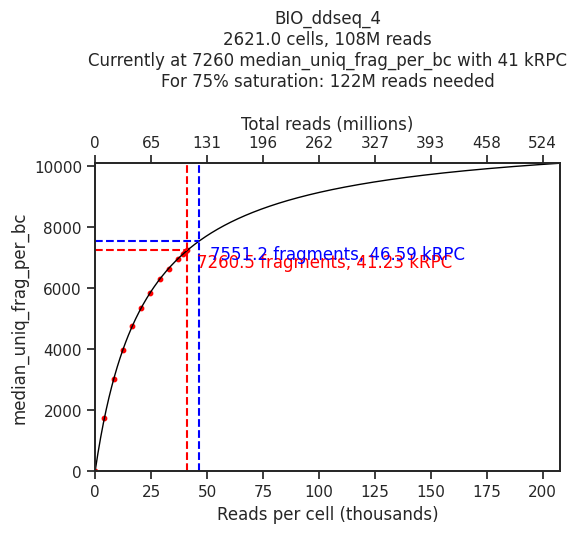

BIO_ddseq_4
2621.0 cells, 108M reads
Currently at 7260 median_uniq_frag_per_bc with 41 kRPC
For 75% saturation: 122M reads needed



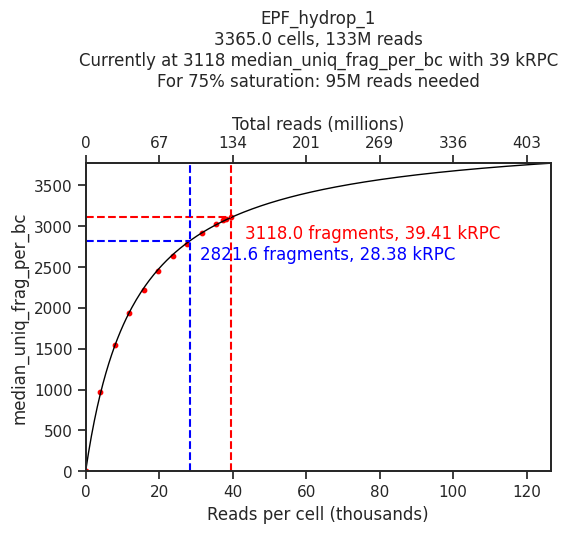

EPF_hydrop_1
3365.0 cells, 133M reads
Currently at 3118 median_uniq_frag_per_bc with 39 kRPC
For 75% saturation: 95M reads needed



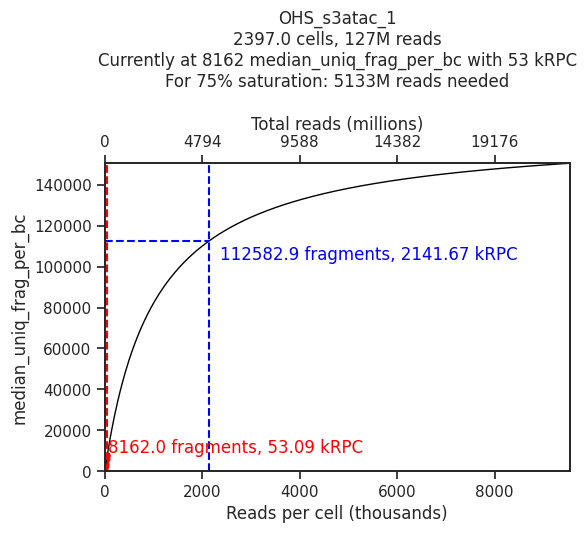

OHS_s3atac_1
2397.0 cells, 127M reads
Currently at 8162 median_uniq_frag_per_bc with 53 kRPC
For 75% saturation: 5133M reads needed



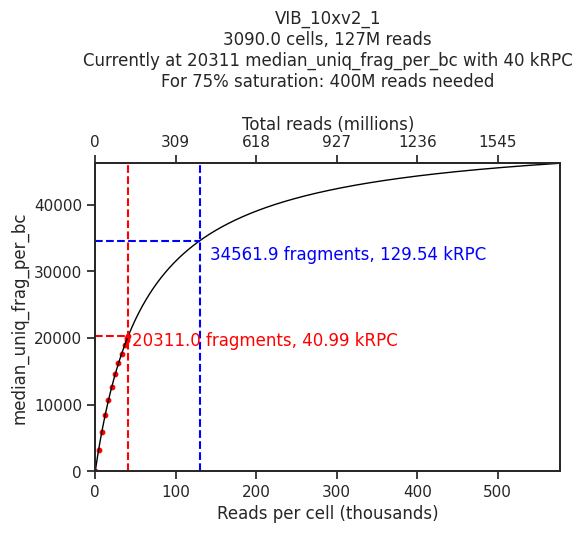

VIB_10xv2_1
3090.0 cells, 127M reads
Currently at 20311 median_uniq_frag_per_bc with 40 kRPC
For 75% saturation: 400M reads needed



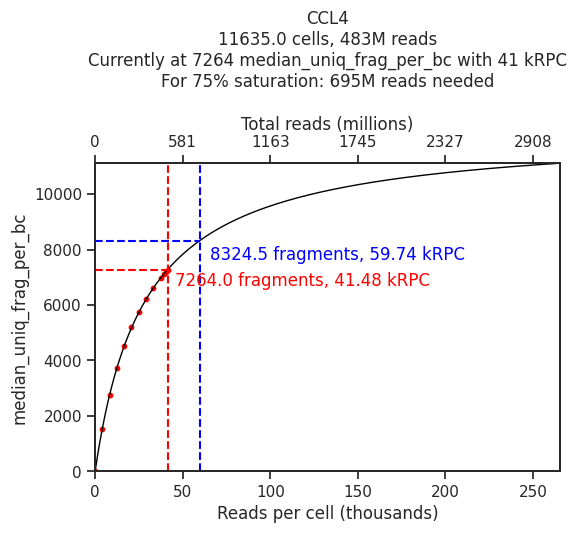

CCL4
11635.0 cells, 483M reads
Currently at 7264 median_uniq_frag_per_bc with 41 kRPC
For 75% saturation: 695M reads needed



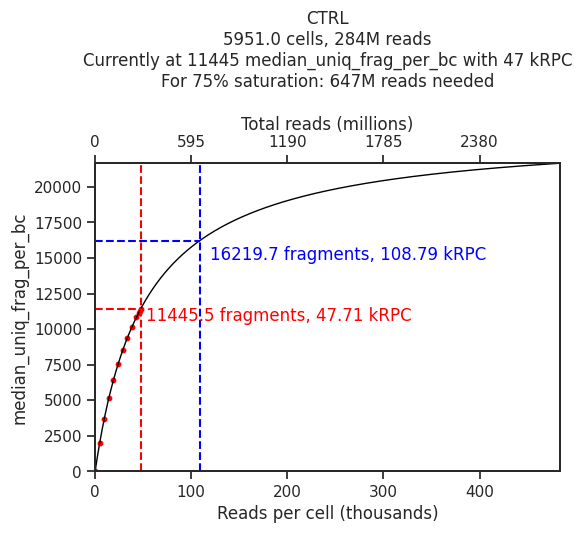

CTRL
5951.0 cells, 284M reads
Currently at 11445 median_uniq_frag_per_bc with 47 kRPC
For 75% saturation: 647M reads needed



In [129]:
for sample in fragments_path_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = df_stats.at[sample, "n_reads"]
    n_cells = df_stats.at[sample, "n_cells"]

    pum.plot_saturation_fragments(
        filepath,
        alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="median_uniq_frag_per_bc",
        function=MM,
        percentage_toplot=percentage_toplot,
        plot_current_saturation=True,
        svg_output_path=f"plots_qc/{sample}__fragments_saturation.svg",
        png_output_path=f"plots_qc/{sample}__fragments_saturation.png",
    )

Now, I want the duplication rate (fraction of fragments that are duplicates) on the y-axis instead. I also want to find the depth where 75% of reads are duplicates.

I use a michaelis-menten kinetic model with a maximum value fixed to 1 (number of duplicates cannot exceed 100%) to fit these values.

In [130]:
def MM_duplication(x, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Km > 0:
        y = x / (Km + x)
    else:
        y = 1e10
    return y

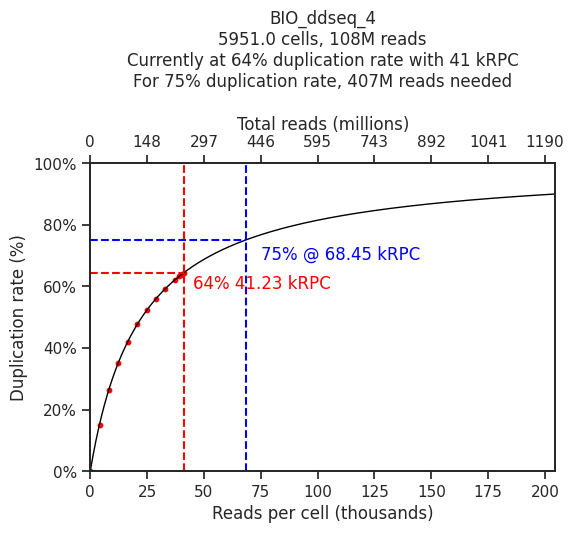

BIO_ddseq_4
5951.0 cells, 108M reads
Currently at 64% duplication rate with 41 kRPC
For 75% duplication rate, 407M reads needed



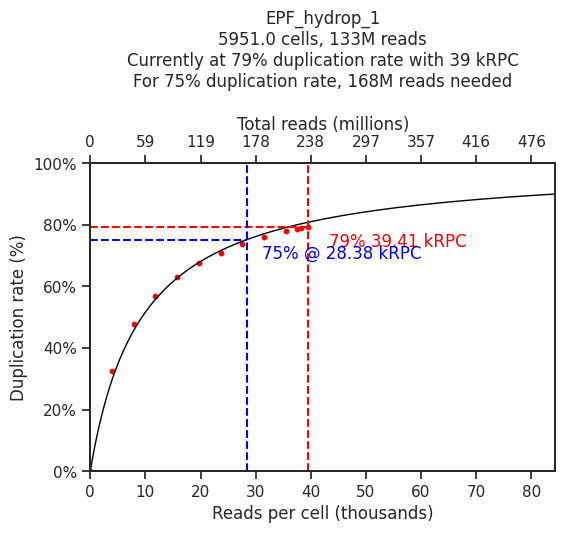

EPF_hydrop_1
5951.0 cells, 133M reads
Currently at 79% duplication rate with 39 kRPC
For 75% duplication rate, 168M reads needed



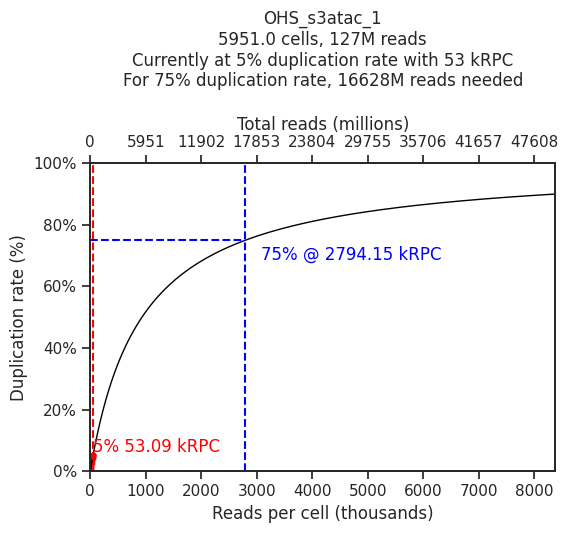

OHS_s3atac_1
5951.0 cells, 127M reads
Currently at 5% duplication rate with 53 kRPC
For 75% duplication rate, 16628M reads needed



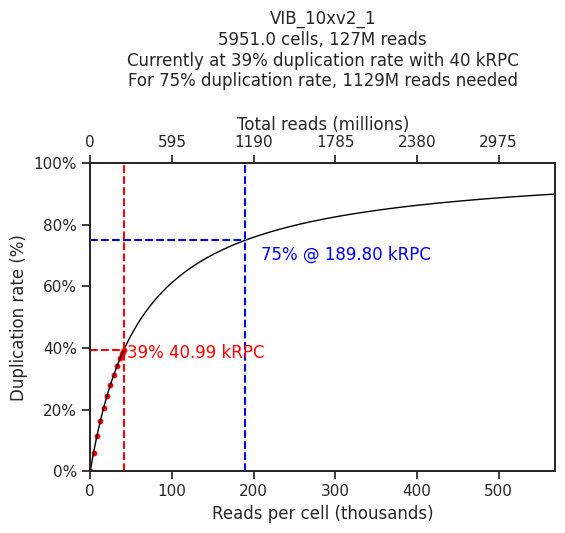

VIB_10xv2_1
5951.0 cells, 127M reads
Currently at 39% duplication rate with 40 kRPC
For 75% duplication rate, 1129M reads needed



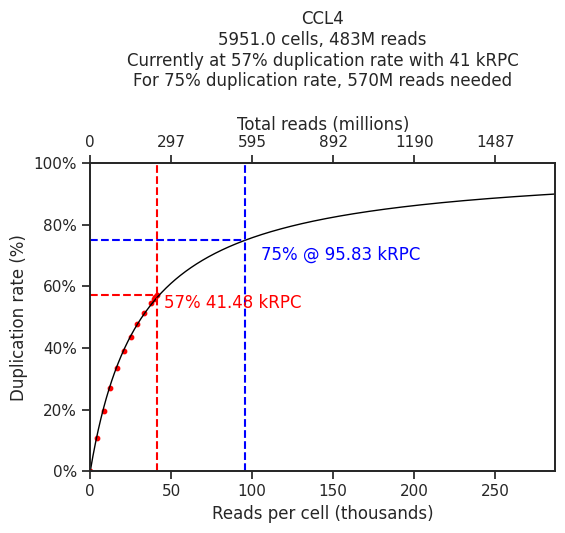

CCL4
5951.0 cells, 483M reads
Currently at 57% duplication rate with 41 kRPC
For 75% duplication rate, 570M reads needed



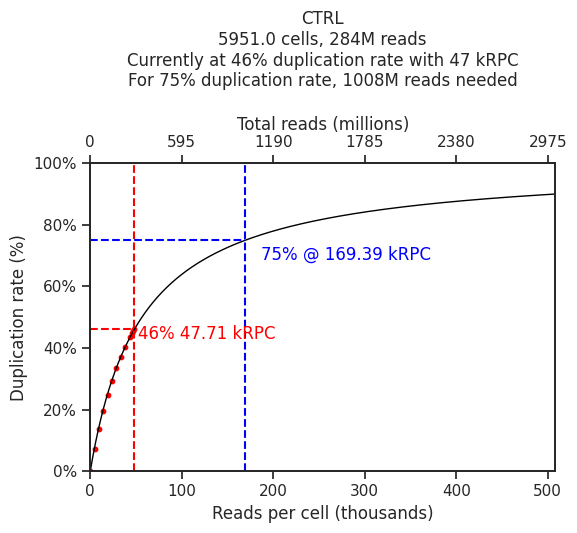

CTRL
5951.0 cells, 284M reads
Currently at 46% duplication rate with 47 kRPC
For 75% duplication rate, 1008M reads needed



In [132]:
for sample in fragments_path_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = df_stats.at[sample, "n_reads"]

    pum.plot_saturation_duplication(
        filepath,
        alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="duplication_rate",
        function=MM_duplication,
        percentage_toplot=percentage_toplot,
        plot_current_saturation=True,
        svg_output_path=f"plots_qc/{sample}__duplication_saturation.svg",
        png_output_path=f"plots_qc/{sample}__duplication_saturation.png",
    )

# Read-downsampled comparison

In [133]:
sampling_stats_path_dict = {
    x.split("/")[-1].split(".sampling")[0]: x
    for x in sorted(glob.glob(f"{saturation_stats_path}/*.sampling_stats.tsv"))
}
sampling_stats_path_dict

{'BIO_ddseq_4': 'saturation_stats/BIO_ddseq_4.sampling_stats.tsv',
 'EPF_hydrop_1': 'saturation_stats/EPF_hydrop_1.sampling_stats.tsv',
 'OHS_s3atac_1': 'saturation_stats/OHS_s3atac_1.sampling_stats.tsv',
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 'saturation_stats/TEW__18d159__fe5107__Multiome_Liver_CCL4.sampling_stats.tsv',
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 'saturation_stats/TEW__703a9e__28aa75__Multiome_Liver_CTRL.sampling_stats.tsv',
 'VIB_10xv2_1': 'saturation_stats/VIB_10xv2_1.sampling_stats.tsv'}

In the following plot, `kRPC` denotes reads per cell (thousands).

In [142]:
df_stats["rpc"] = df_stats["n_reads"] / df_stats["n_cells"]

The lowest depth is:

In [144]:
df_stats["rpc"].min()

39425.18306092125

We can take this value as the level to which we virtually downsample every other sample. However, there is a caveat: if you downsample too much, you will favour methods that saturate faster. The inverse is also true.

In [145]:
to_downsample = df_stats["rpc"].min()

In [134]:
def MM(x, Vmax, Km):
    """
    Define the Michaelis-Menten Kinetics model that will be used for the model fitting.
    """
    if Vmax > 0 and Km > 0:
        y = (Vmax * x) / (Km + x)
    else:
        y = 1e10
    return y

In [176]:
from scipy.optimize import curve_fit


import numpy as np


def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def get_fit(
    filepath,
    sample,
    n_reads,
    n_cells,
    to_downsample,
    x_axis="mean_reads_per_barcode",
    y_axis="median_uniq_frag_per_bc",
    function=MM,
):
    stats_df = pd.read_csv(filepath, sep="\t", index_col=0)

    stats_df["total_reads"] = n_reads * stats_df.index

    stats_df["mean_reads_per_barcode"] = (
        stats_df["total_reads"] / stats_df["cell_barcode_count"]
    )
    stats_df["mean_reads_per_barcode"].fillna(0, inplace=True)
    stats_df["duplication_rate"] = (
        stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]
    ) / stats_df["total_frag_count"]
    stats_df["duplication_rate"] = stats_df["duplication_rate"].fillna(0)
    # stats_df["duplication_rate"] = (stats_df["total_frag_count"] - stats_df["total_unique_frag_count"]/stats_df["total_frag_count"])
    # select x/y data fro MM fit from subsampling stats
    x_data = np.array(stats_df.loc[0:, x_axis]) / 10**3
    y_data = np.array(stats_df.loc[0:, y_axis])
    # fit to MM function

    best_fit_ab, covar = curve_fit(function, x_data, y_data, bounds=(0, +np.inf))

    # expand fit space
    x_fit = np.linspace(0, int(np.max(x_data) * 1000), num=100000)
    y_fit = function(x_fit, *(best_fit_ab))

    # Find read count for percent given depth
    curr_x_idx = list(x_fit).index(find_nearest(x_fit, to_downsample / 1000))
    curr_y_coef = y_fit[curr_x_idx]

    return curr_y_coef

In [177]:
downsampled_median_uniq_frag_per_bc_dict = {}
for sample in fragments_path_dict.keys():
    filepath = sampling_stats_path_dict[sample]
    n_reads = df_stats.at[sample, "n_reads"]
    n_cells = df_stats.at[sample, "n_cells"]

    downsampled_median_uniq_frag_per_bc = get_fit(
        filepath,
        alias_dict[sample],
        n_reads,
        n_cells,
        x_axis="mean_reads_per_barcode",
        y_axis="median_uniq_frag_per_bc",
        function=MM,
        to_downsample=to_downsample,
    )

    downsampled_median_uniq_frag_per_bc_dict[
        sample
    ] = downsampled_median_uniq_frag_per_bc

In [178]:
downsampled_median_uniq_frag_per_bc_dict

{'BIO_ddseq_4': 7140.286107610938,
 'EPF_hydrop_1': 3103.7405322947493,
 'OHS_s3atac_1': 6122.098849223496,
 'VIB_10xv2_1': 19809.634089354742,
 'TEW__18d159__fe5107__Multiome_Liver_CCL4': 7132.149608244996,
 'TEW__703a9e__28aa75__Multiome_Liver_CTRL': 10353.112725326051}